Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta, datetime
from itertools import combinations

# Modelling imports
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns_general_width   = 16
sns_general_height  = 8
sns.set(rc={'figure.figsize':(sns_general_width, sns_general_height)})
POPULATION_THRESHOLD = 1000000
ANALYSIS_END_DATE = '2022-04-01'

## ETL

Utilities

In [3]:
# Special codes with the exception of Kosovo (OWID_KOS)
special_owid_codes = ('OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM',
       'OWID_CYN', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC', 'OWID_WRL')

In [4]:
def space_and_title_case(text):
    return text.replace('_', ' ').title()

In [5]:
def plot_full(countries, df, title, metric, date="date"):
    for country in countries:
        _df = df[df['country'] == country]
        plt.plot(_df[date], _df[metric])
    plt.title(title)
    plt.ylabel(space_and_title_case(metric))
    plt.xlabel('Time')

def plot_summary(df, title, metric, date='date', remove_mean=False):
    if not remove_mean:
        df = df.groupby(date).agg(
                mean=(metric,"mean"), 
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    else:
        df = df.groupby(date).agg(
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    df.plot(df.columns[0], df.columns[1:]) # date vs mean, median, 5th, 95th
    plt.title(title)
    plt.ylabel(space_and_title_case(metric))
    plt.xlabel('Time')

### Stringency

In [6]:
stringency_df = pd.read_csv('data/general/owid-covid-data.csv')[['location', 'iso_code', 'date', 'stringency_index']]
stringency_df.rename(columns={
    # "Entity":"country",
    "location":"country",
    # "Code":"code",
    "iso_code":"code",
    # "Day":"date"
    },
    inplace=True)
stringency_df['date'] = pd.to_datetime(stringency_df['date'])
stringency_df = stringency_df[stringency_df['date'] < ANALYSIS_END_DATE]

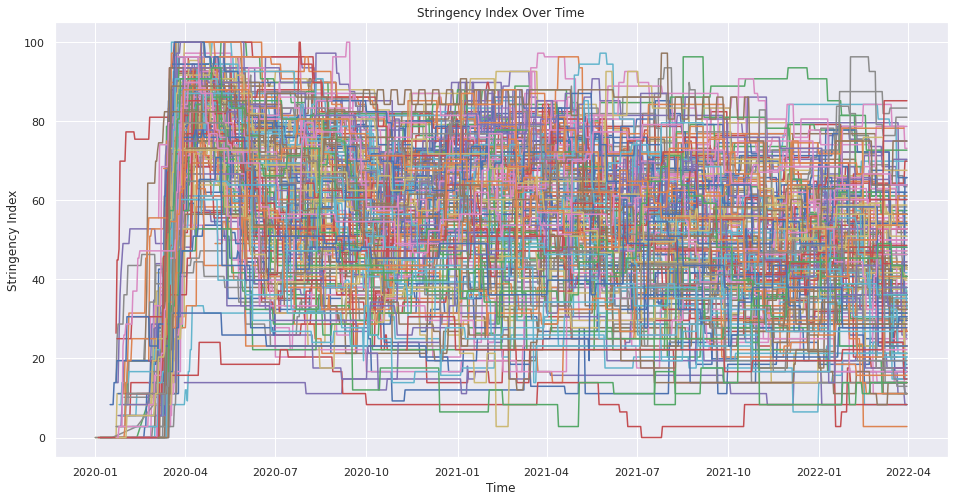

In [7]:
countries = stringency_df['country'].unique()
plot_full(countries, stringency_df, title='Stringency Index Over Time', metric='stringency_index')

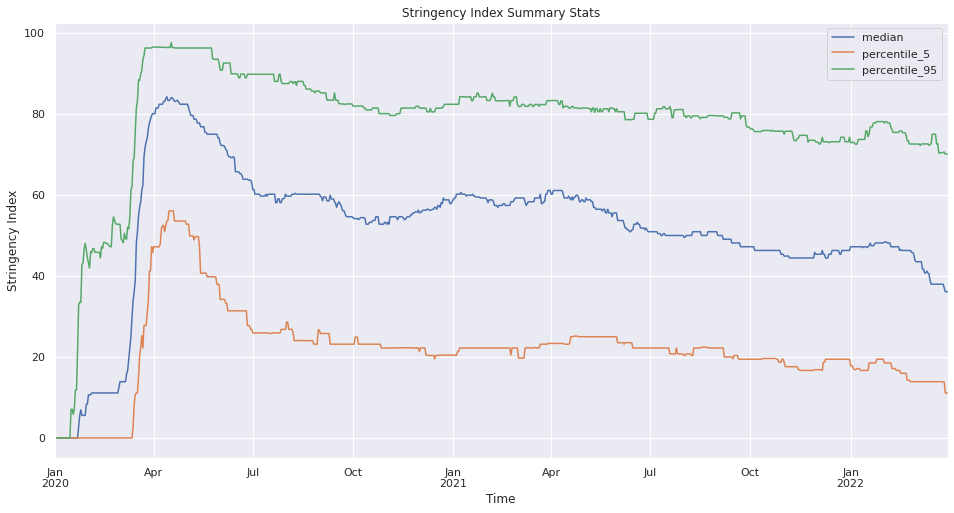

In [8]:
plot_summary(stringency_df, title='Stringency Index Summary Stats', metric='stringency_index', remove_mean=True)

---

### Containment/Health

In [9]:
containment_health_df = pd.read_csv('data/stringency/covid-containment-and-health-index.csv')
containment_health_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
containment_health_df['date'] = pd.to_datetime(containment_health_df['date'])
containment_health_df = containment_health_df[containment_health_df['date'] < ANALYSIS_END_DATE]

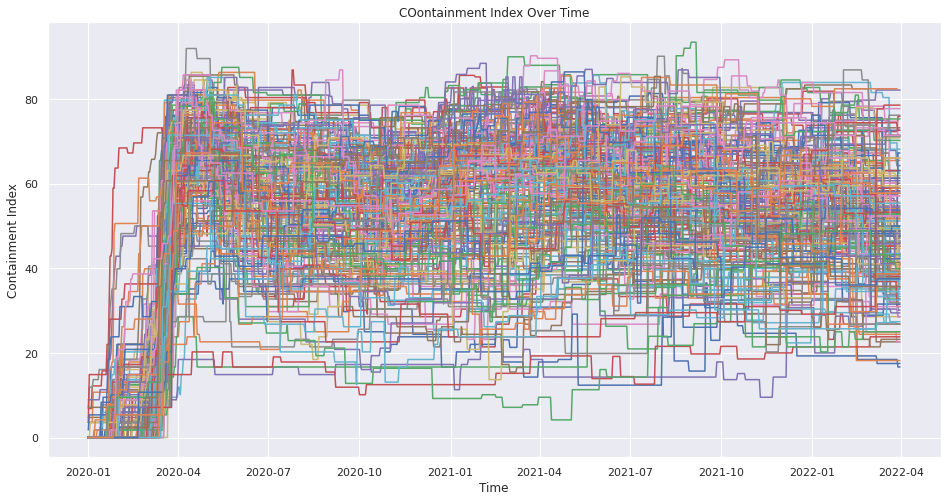

In [10]:
plot_full(countries, containment_health_df, title='COontainment Index Over Time', metric='containment_index')

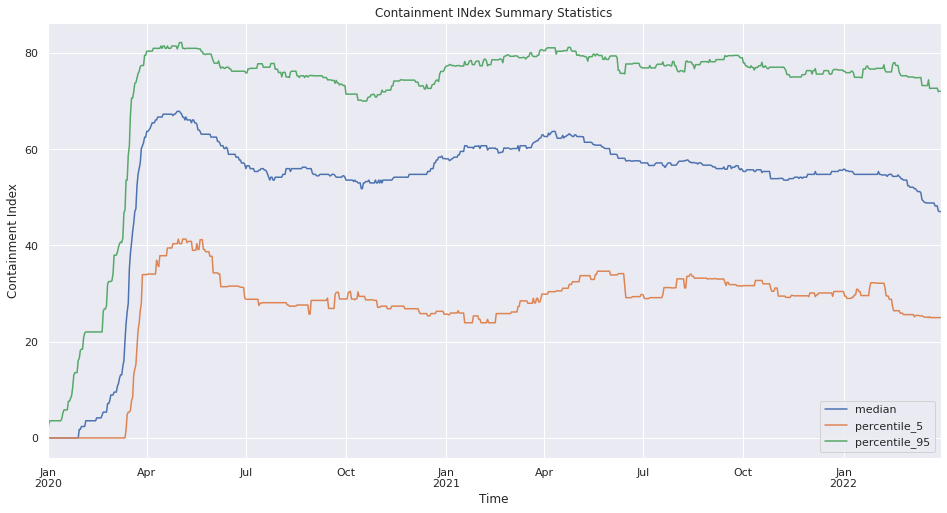

In [11]:
plot_summary(containment_health_df, title='Containment INdex Summary Statistics', metric='containment_index', remove_mean=True)

### Deaths
Deaths can be an intensity metric

In [12]:
covid_history_df = pd.read_csv('data/general/owid-covid-data.csv')
covid_history_df.rename(columns={
    "location":"country",
    "iso_code":"code"},
    inplace=True)
covid_history_df['date'] = pd.to_datetime(covid_history_df['date'])
covid_history_df = covid_history_df[covid_history_df['date'] < ANALYSIS_END_DATE]

owid_aggregations_df = covid_history_df[covid_history_df['code'].isin(special_owid_codes)]
owid_aggregations_df.rename(columns={
    "country":"category"},
    inplace=True)

covid_history_df = covid_history_df[~covid_history_df['code'].isin(special_owid_codes)].sort_values(by=['code', 'date'])

In [13]:
income_levels = [level for level in owid_aggregations_df["category"].unique() if level.endswith("income")]
income_levels

['High income', 'Low income', 'Lower middle income', 'Upper middle income']

In [14]:
# remove rows for any country before it makes a contribution to the data
def remove_rows_before_contributions():
    for code in covid_history_df.code.unique():
        _df = covid_history_df[covid_history_df['code'] == code]
        for row in _df.itertuples():
            if (row.new_cases == 0 or row.new_cases is None) and (row.total_cases == 0 or row.total_cases is None):
                covid_history_df.drop(index=row.Index, inplace=True)
                break
        continue
remove_rows_before_contributions()

Deaths per million

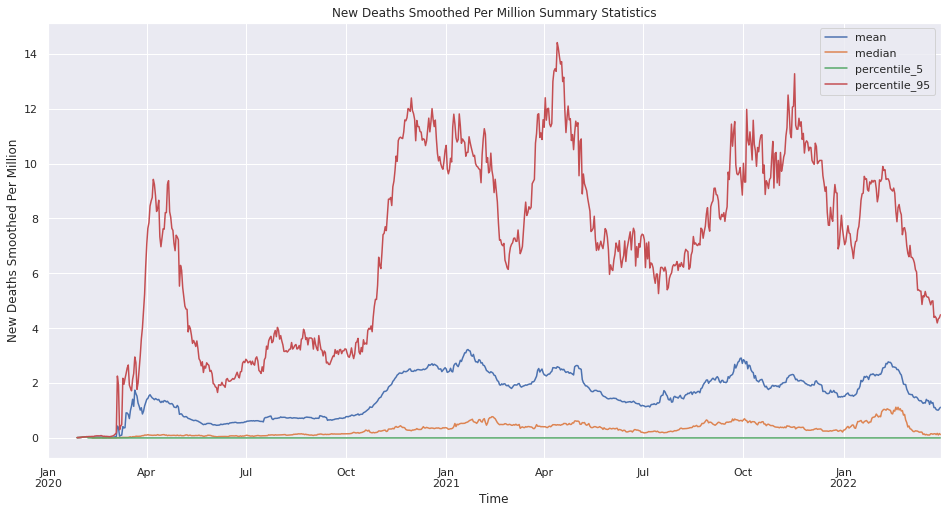

In [15]:
plot_summary(covid_history_df, title='New Deaths Smoothed Per Million Summary Statistics', metric="new_deaths_smoothed_per_million")

Mortality

In [16]:
# Align the zeros of the two y-axes
# Adapted from: https://stackoverflow.com/a/54355867/6712832
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

(0.0, 75.0)

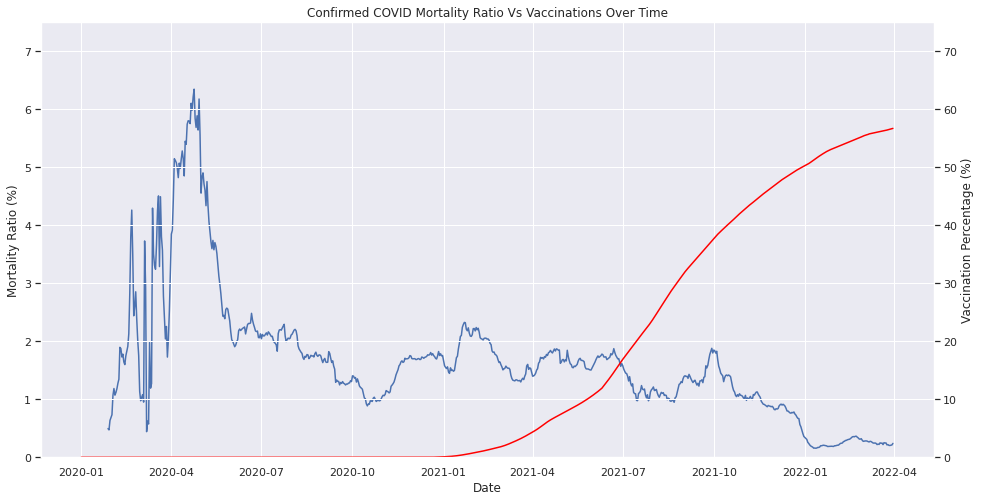

In [17]:
mortality_df = covid_history_df.groupby('date').agg('sum').reset_index()
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
fig, ax = plt.subplots()

ax.plot(mortality_df['date'], 100*mortality_df['new_deaths_smoothed_per_million']/mortality_df['new_cases_smoothed_per_million'], label='Mortality Ratio')
ax.set_title('Confirmed COVID Mortality Ratio Vs Vaccinations Over Time')
ax.set_ylabel('Mortality Ratio (%)')
ax.set_xlabel('Date')

ax_twin = ax.twinx()
ax_twin.plot(mortality_df['date'], 100*np.cumsum(mortality_df['new_people_vaccinated_smoothed'])/mortality_df['population'], color='red', label='Vaccination Percentage')

ax_twin.set_ylabel('Vaccination Percentage (%)')
# align_yaxis(ax, ax_twin)
ax.set_ylim([0, 7.5])
ax_twin.set_ylim([0, 75])

# Standard error for mortality ratio. Formula here: https://www.statology.org/standard-error-of-proportion/


### Mobility

In [18]:
mobility_df = pd.read_csv("data/mobility/changes-visitors-covid.csv")
mobility_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
mobility_df['date'] = pd.to_datetime(mobility_df['date'])
mobility_df = mobility_df[mobility_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(covid_history_df, mobility_df, how="outer", on=["country", "code", "date"])

debt_relief_df = pd.read_csv("data/income_relief/debt-relief-covid.csv")
debt_relief_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
debt_relief_df['date'] = pd.to_datetime(debt_relief_df['date'])
debt_relief_df = debt_relief_df[debt_relief_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, debt_relief_df, how="outer", on=["country", "code", "date"])

income_support_df = pd.read_csv("data/income_relief/income-support-covid.csv")
income_support_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date",
    "income_support":"income_support_index"},
    inplace=True)
income_support_df['date'] = pd.to_datetime(income_support_df['date'])
income_support_df = income_support_df[income_support_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, income_support_df, how="outer", on=["country", "code", "date"])

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178840 entries, 0 to 178839
Data columns (total 75 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   code                                        178840 non-null  object        
 1   continent                                   165284 non-null  object        
 2   country                                     178840 non-null  object        
 3   date                                        178840 non-null  datetime64[ns]
 4   total_cases                                 158934 non-null  float64       
 5   new_cases                                   158814 non-null  float64       
 6   new_cases_smoothed                          157710 non-null  float64       
 7   total_deaths                                141084 non-null  float64       
 8   new_deaths                                  140931 non-null  float64      

Optimizing lag

In [20]:
_sub_df  = merged_df[merged_df['date'] <= '2020-12-31'] # test appropriate compliance lag is most useful in 2020 
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = _sub_df['stringency_index'].corr(_sub_df['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.6825812691310847


In [21]:
# Optimizing lag on a country by country basis would look like this:
# greatest_abs_corr = 0
# for lag in range(0,90):
#     _corr = merged_df[merged_df['country'] == 'United Kingdom']['stringency_index'].corr(merged_df[merged_df['country'] == 'United Kingdom']['residential'].shift(lag))
#     # print(_corr)
#     if abs(_corr) > greatest_abs_corr:
#         greatest_abs_corr = abs(_corr)
#         print(f"{lag} days lag: {_corr}")

---

Modelling utility functions

In [22]:
def feature_engineering(df, y_feature, keep_country=False, drop_features=None, 
                        add_logs=True, add_squares=True, cross_features=False, y_lag=0, 
                        log_exclude=['income_support_index', 'debt_relief'], 
                        square_exclude=['income_support_index', 'debt_relief']):
    if drop_features is not None:
        df = df.drop(columns=drop_features)
    df_copy = df.copy()

    df_copy[y_feature] = df_copy[y_feature].shift(-y_lag)

    y = df_copy[y_feature]
    X = df_copy.drop([y_feature], axis=1)
    X_columns = X.columns[1:]

    for col in X_columns:
        if is_numeric_dtype(X[col]):
            if add_logs:
                if col not in log_exclude:
                    X[f"{col}_log"] = np.log(X[col])
            if add_squares:
                if col not in square_exclude:
                    X[f"{col}_squared"] = X[col]**2

    # Cross-feature combinations
    if cross_features:
        for combo in combinations(X.columns[1:], 2):
            X[f"{combo[0]}_{combo[1]}"] = X[combo[0]] * X[combo[1]]
    
    X['y'] = y
    X.dropna(inplace=True)
    y = X['y']
    X = X.drop(['y'], axis=1)
    if not keep_country:
        X = X.drop(['country'], axis=1)
    
    return X, y

In [23]:
# https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
def forward_regression(X, y,
                       threshold_in=0.05,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out=0.05,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

---


In [24]:
merged_df[merged_df['continent']=='Oceania'].sort_values('population_density', ascending=False)['population_density'].unique()

array([682.45 , 373.067, 304.128, 295.15 , 150.777, 150.028, 143.701,
       119.878,  77.324,  69.413,  49.562,  47.237,  22.662,  21.841,
        18.22 ,  18.206,  15.342,   3.202,     nan])

In [25]:
merged_df[merged_df['continent']=='Oceania'].sort_values('population_density', ascending=False)['country'].unique()

array(['Nauru', 'Tuvalu', 'Guam', 'Marshall Islands',
       'Micronesia (country)', 'Tonga', 'Kiribati',
       'Northern Mariana Islands', 'French Polynesia', 'Samoa', 'Fiji',
       'Palau', 'Vanuatu', 'Solomon Islands', 'Papua New Guinea',
       'New Zealand', 'New Caledonia', 'Australia', 'Cook Islands',
       'Niue', 'Pitcairn', 'Tokelau', 'Wallis and Futuna'], dtype=object)

### Q1. Headline
* Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
* Mortality ratio (Derived from cases and deaths) - how deadly is it?
* Stringency over time  - how are governments responding?
* Mobility over time - how are people reacting?


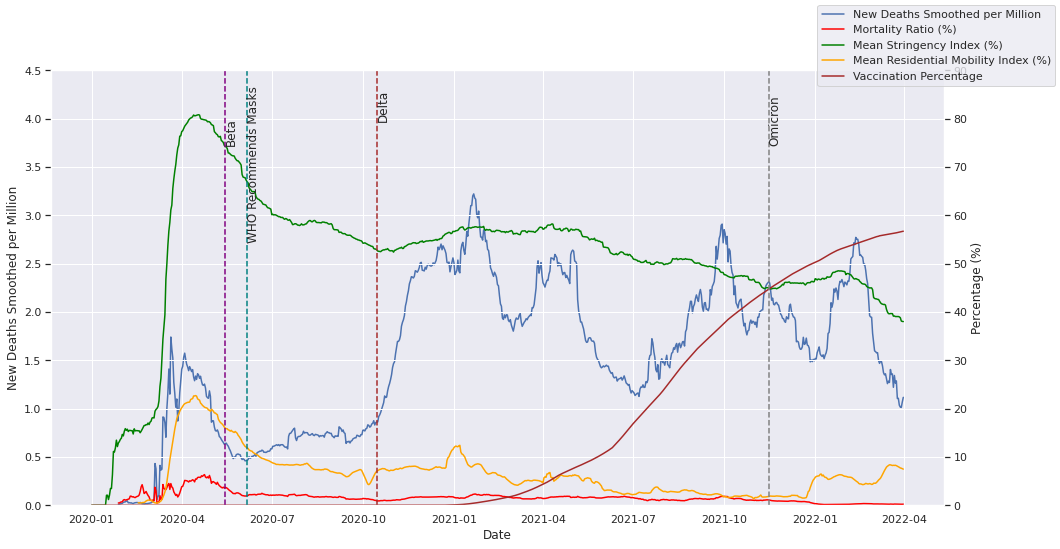

In [26]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

date_sum_df['mortality_ratio'] = 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million']

# For use much later
global_dates, global_stringency = date_mean_df['date'], date_mean_df['stringency_index']

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_percentages = ax.twinx()
ax_twin_percentages.plot(date_sum_df['date'], date_sum_df['mortality_ratio'], label='Mortality Ratio (%)', color='red')
ax_twin_percentages.set_ylabel('Percentage (%)')

# Stringency over time  - how are governments responding?
ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index (%)', color='green')

ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

ax.set_ylim(0, 4.5)
ax_twin_percentages.set_ylim(0, 90)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax_twin_percentages.axvline(x='2020-05-15', linestyle='--', color='purple')
ax_twin_percentages.text('2020-05-15',75,'Beta',rotation=90)
ax_twin_percentages.axvline(x='2020-10-15', linestyle='--', color='brown')
ax_twin_percentages.text('2020-10-15',80,'Delta',rotation=90)
ax_twin_percentages.axvline(x='2021-11-15', linestyle='--', color='gray')
ax_twin_percentages.text('2021-11-15',75,'Omicron',rotation=90)
ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
ax_twin_percentages.text('2020-06-06',55,'WHO Recommends Masks',rotation=90)
fig.legend()

In [27]:
date_mean_df.iloc[np.argmax(date_mean_df['new_cases_smoothed_per_million'])]['stringency_index']
# row = date_mean_df[date_mean_df['date']=='2020-06-06'].iloc[0]
# row['new_cases_smoothed_per_million']

48.47424731182793

In [28]:
pd.Series([386.21, 1157.7]).pct_change()

0         NaN
1    1.997592
dtype: float64

In [29]:
# key date playground
# date_mean_df[date_mean_df['date'] == '2021-11-15']['residential']

Changes in correlation over time

In [30]:
# Global compliance in the pre-vaccine period
temp_df = date_mean_df[date_mean_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
print(temp_df['residential'].corr(temp_df['stringency_index']))

0.9663217534266699


In [31]:
import matplotlib.ticker as ticker

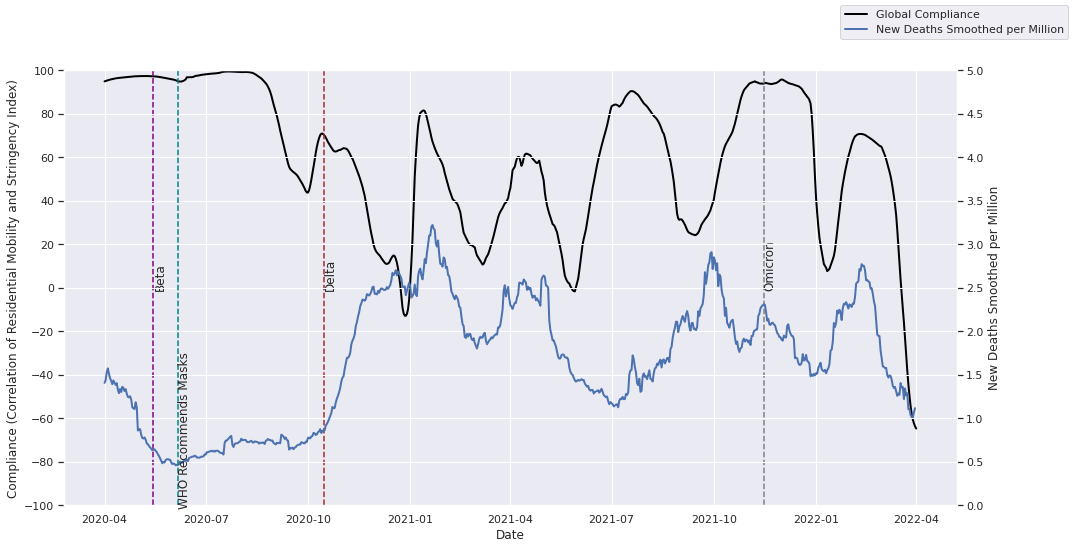

In [32]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 90 # Averaging window of 3 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

date_mean_df = merged_df.groupby('date').agg('mean').reset_index()
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])


df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

fig, ax = plt.subplots()
        
residential_corr = []
end_dates = []
row_list = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    row_list.append((list(window['date'])[0] + timedelta(days=rolling_window), 100 * window[['residential','stringency_index']].corr()['stringency_index'][0]))
_3_month_compliance = pd.DataFrame(row_list, columns=['date', 'compliance'])
_3_month_compliance['date'] = pd.to_datetime(_3_month_compliance['date'])
# ax.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Global Compliance", color="black", linewidth=2)
ax.plot(_3_month_compliance['date'][panic_window:], _3_month_compliance['compliance'][panic_window:], label="Global Compliance", color="black", linewidth=2)

ax_twin_deaths = ax.twinx()
ax_twin_deaths.plot(date_mean_df[date_mean_df['date']>='2020-04-01']['date'], 
                    date_mean_df[date_mean_df['date']>='2020-04-01']['new_deaths_smoothed_per_million'], 
                    label='New Deaths Smoothed per Million', linewidth=2)
ax_twin_deaths.set_ylabel('New Deaths Smoothed per Million')

ax.set_ylim(-100, 100)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax_twin_deaths.set_ylim(0, 5)
ax_twin_deaths.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax.axvline(x='2020-05-15', linestyle='--', color='purple')
ax.text('2020-05-15',0,'Beta',rotation=90)
ax.axvline(x='2020-10-15', linestyle='--', color='brown')
ax.text('2020-10-15', 0,'Delta',rotation=90)
ax.axvline(x='2021-11-15', linestyle='--', color='gray')
ax.text('2021-11-15', 0,'Omicron',rotation=90)
plt.axvline(x='2020-06-06', linestyle='--', color='teal')
plt.text('2020-06-06', 0,'WHO Recommends Masks',rotation=90)

fig.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Compliance (Correlation of Residential Mobility and Stringency Index)")
plt.show()

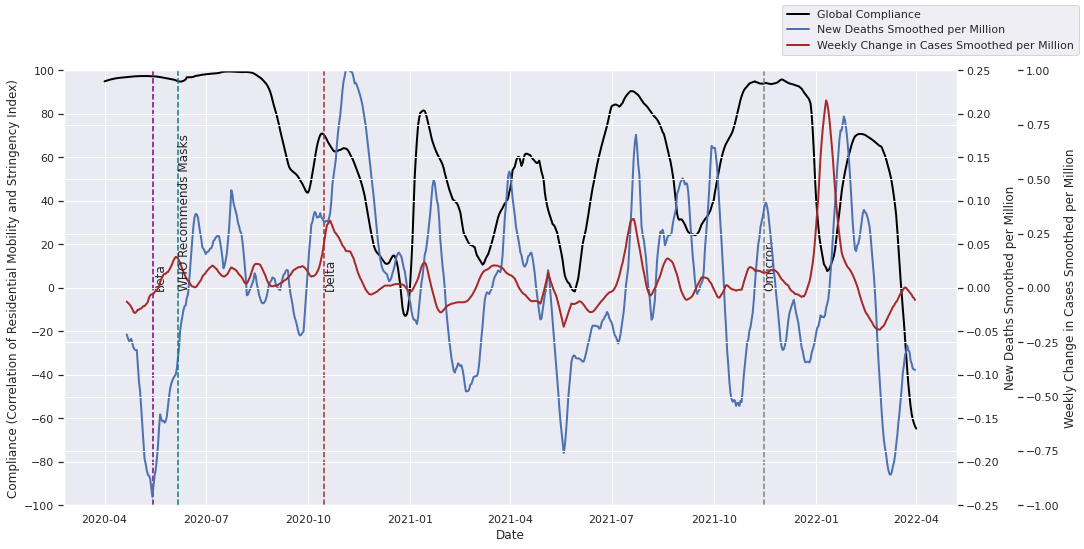

In [33]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 90 # Averaging window of 3 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

date_mean_df = merged_df.groupby('date').agg('mean').reset_index()
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])


df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

fig, ax = plt.subplots()
        
residential_corr = []
end_dates = []
row_list = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    row_list.append((list(window['date'])[0] + timedelta(days=rolling_window), 100 * window[['residential','stringency_index']].corr()['stringency_index'][0]))
_3_month_compliance = pd.DataFrame(row_list, columns=['date', 'compliance'])
_3_month_compliance['date'] = pd.to_datetime(_3_month_compliance['date'])
# ax.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Global Compliance", color="black", linewidth=2)
ax.plot(_3_month_compliance['date'][panic_window:], _3_month_compliance['compliance'][panic_window:], label="Global Compliance", color="black", linewidth=2)

ax_twin_cases = ax.twinx()
ax_twin_cases.plot(date_mean_df[date_mean_df['date']>='2020-04-01']['date'], 
                    date_mean_df[date_mean_df['date']>='2020-04-01']['new_cases_smoothed_per_million'].rolling(14).mean().pct_change(7), 
                    label='Weekly Change in Cases Smoothed per Million', linewidth=2, color='blue')
ax_twin_cases.set_ylabel('Weekly Change in Cases Smoothed per Million')
ax_twin_cases.spines['right'].set_position(('outward', 60))

ax_twin_deaths = ax.twinx()
ax_twin_deaths.plot(date_mean_df[date_mean_df['date']>='2020-04-01']['date'], 
                    date_mean_df[date_mean_df['date']>='2020-04-01']['new_deaths_smoothed_per_million'].rolling(14).mean().pct_change(7), 
                    label='New Deaths Smoothed per Million', linewidth=2, color='brown')
ax_twin_deaths.set_ylabel('New Deaths Smoothed per Million')



ax.set_ylim(-100, 100)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax_twin_deaths.set_ylim(-0.25, 0.25)
ax_twin_deaths.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax_twin_cases.set_ylim(-1, 1)
# ax_twin_deaths.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax.axvline(x='2020-05-15', linestyle='--', color='purple')
ax.text('2020-05-15',0,'Beta',rotation=90)
ax.axvline(x='2020-10-15', linestyle='--', color='brown')
ax.text('2020-10-15', 0,'Delta',rotation=90)
ax.axvline(x='2021-11-15', linestyle='--', color='gray')
ax.text('2021-11-15', 0,'Omicron',rotation=90)
plt.axvline(x='2020-06-06', linestyle='--', color='teal')
plt.text('2020-06-06', 0,'WHO Recommends Masks',rotation=90)

fig.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Compliance (Correlation of Residential Mobility and Stringency Index)")
plt.show()

In [34]:
# date_mean_df['re_smoothed_deaths'] = date_mean_df['new_deaths_smoothed_per_million'].rolling(window=rolling_window).mean()
_3_month_compliance['date'], _3_month_compliance['compliance'] = _3_month_compliance['date'][panic_window:], _3_month_compliance['compliance'][panic_window:]
corr_death_merged_df = _3_month_compliance.merge(date_mean_df[['date','new_deaths_smoothed_per_million']], how='outer', on='date')

In [35]:
print("="*10, "Deaths","="*10)
# Entire correlation
print("Entire Period:", corr_death_merged_df['compliance'].corr(corr_death_merged_df['new_deaths_smoothed_per_million']))

# Pre-delta
print("Beta:", corr_death_merged_df[corr_death_merged_df['date'] <= '2020-10-15']['compliance'].corr(corr_death_merged_df[corr_death_merged_df['date'] <= '2020-10-15']['new_deaths_smoothed_per_million']))

# Delta to omicron
print("Delta:", corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-10-15') &\
                                                (corr_death_merged_df['date'] <= '2021-11-15')]['compliance'].corr(
                                                    corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-10-15') &\
                                                                        (corr_death_merged_df['date'] <= '2021-11-15')]['new_deaths_smoothed_per_million']))

# Post-omicron
print("Omicron:", corr_death_merged_df[corr_death_merged_df['date'] >= '2021-11-15']['compliance'].corr(corr_death_merged_df[corr_death_merged_df['date'] >= '2021-11-15']['new_deaths_smoothed_per_million']))


# Pre=-vax
print("Pre-vax:", corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-04-01') &\
                                                (corr_death_merged_df['date'] <= '2020-12-31')]['compliance'].corr(
                                                    corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-04-01') &\
                                                                        (corr_death_merged_df['date'] <= '2020-12-31')]['new_deaths_smoothed_per_million']))


========== Deaths ==========
Entire Period: -0.40414778853228117
Beta: 0.04205326061942116
Delta: -0.24929163831889825
Omicron: 0.5585842139261201
Pre-vax: -0.807076437820322


Text(0, 0.5, 'Correlation between compliance and deaths')

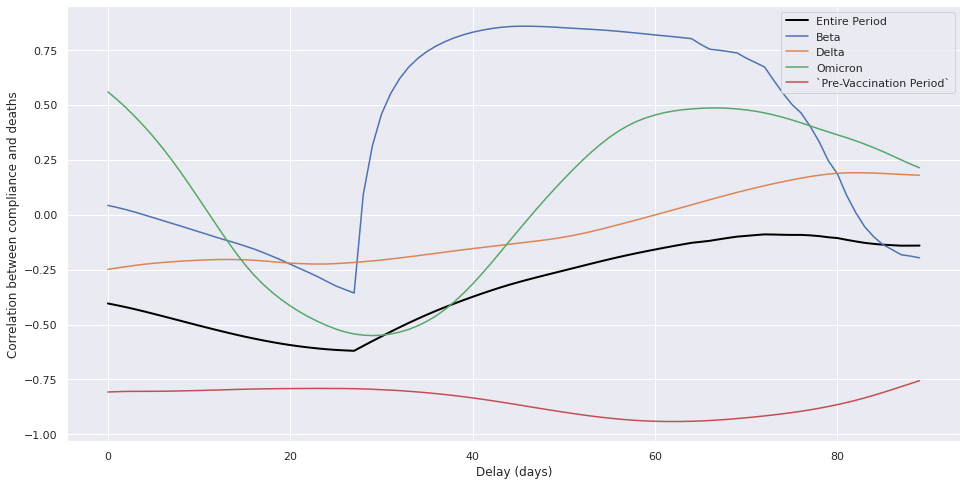

In [36]:
# Deaths vs compliance
entire = []
pre_delta = []
delta_omicron = []
omicron = []
prevax = []
for lag in range(90):
    corr_death_merged_df[f'compliance_{lag}'] = corr_death_merged_df['compliance'].shift(lag)
    entire.append(corr_death_merged_df['new_deaths_smoothed_per_million'].corr(corr_death_merged_df[f'compliance_{lag}']))
    pre_delta.append(corr_death_merged_df[corr_death_merged_df['date'] <= '2020-10-15']['new_deaths_smoothed_per_million'].corr(
                    corr_death_merged_df[corr_death_merged_df['date'] <= '2020-10-15'][f'compliance_{lag}']))
    delta_omicron.append(corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-10-15') &\
                                                (corr_death_merged_df['date'] <= '2021-11-15')]['new_deaths_smoothed_per_million'].corr(
                                                    corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-10-15') &\
                                                                        (corr_death_merged_df['date'] <= '2021-11-15')][f'compliance_{lag}']))
    omicron.append(corr_death_merged_df[corr_death_merged_df['date'] >= '2021-11-15']['new_deaths_smoothed_per_million'].corr(
                    corr_death_merged_df[corr_death_merged_df['date'] >= '2021-11-15'][f'compliance_{lag}']))
    prevax.append(corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-04-01') &\
                                                (corr_death_merged_df['date'] <= '2020-12-31')]['new_deaths_smoothed_per_million'].corr(
                                                    corr_death_merged_df[(corr_death_merged_df['date'] >= '2020-04-01') &\
                                                                        (corr_death_merged_df['date'] <= '2020-12-31')][f'compliance_{lag}']))
plt.plot(range(90), entire, label="Entire Period", linewidth=2, color='black')
plt.plot(range(90), pre_delta, label="Beta")
plt.plot(range(90), delta_omicron, label="Delta")
plt.plot(range(90), omicron, label="Omicron")
plt.plot(range(90), prevax, label="`Pre-Vaccination Period`")
plt.legend()
plt.xlabel("Delay (days)")
plt.ylabel("Correlation between compliance and deaths")

Text(0, 0.5, 'Correlation between stringency and deaths')

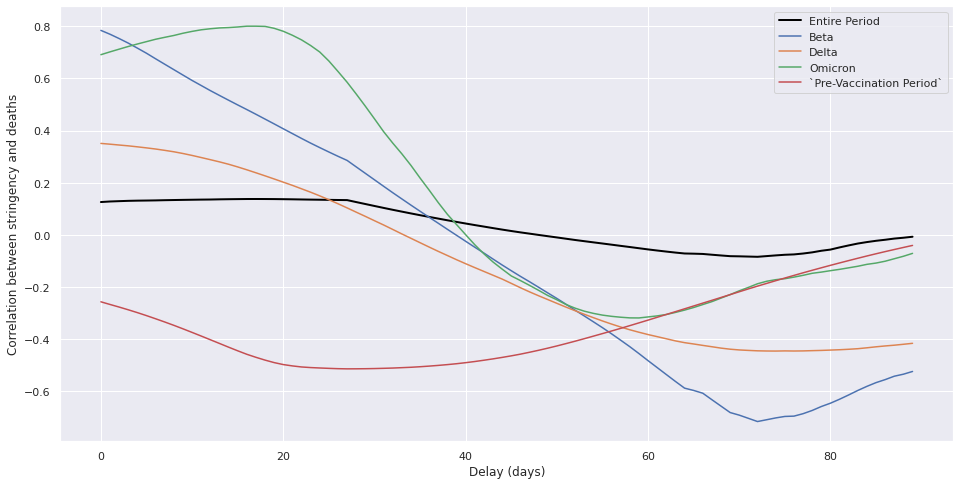

In [37]:
# Deaths vs stringency
entire = []
pre_delta = []
delta_omicron = []
omicron = []
prevax = []
for lag in range(90):
    date_mean_df[f'stringency_{lag}'] = date_mean_df['stringency_index'].shift(lag)
    entire.append(date_mean_df['new_deaths_smoothed_per_million'].corr(date_mean_df[f'stringency_{lag}']))
    pre_delta.append(date_mean_df[date_mean_df['date'] <= '2020-10-15']['new_deaths_smoothed_per_million'].corr(
                    date_mean_df[date_mean_df['date'] <= '2020-10-15'][f'stringency_{lag}']))
    delta_omicron.append(date_mean_df[(date_mean_df['date'] >= '2020-10-15') &\
                                                (date_mean_df['date'] <= '2021-11-15')]['new_deaths_smoothed_per_million'].corr(
                                                    date_mean_df[(date_mean_df['date'] >= '2020-10-15') &\
                                                                        (date_mean_df['date'] <= '2021-11-15')][f'stringency_{lag}']))
    omicron.append(date_mean_df[date_mean_df['date'] >= '2021-11-15']['new_deaths_smoothed_per_million'].corr(
                    date_mean_df[date_mean_df['date'] >= '2021-11-15'][f'stringency_{lag}']))
    prevax.append(date_mean_df[(date_mean_df['date'] >= '2020-04-01') &\
                                                (date_mean_df['date'] <= '2020-12-31')]['new_deaths_smoothed_per_million'].corr(
                                                    date_mean_df[(date_mean_df['date'] >= '2020-04-01') &\
                                                                        (date_mean_df['date'] <= '2020-12-31')][f'stringency_{lag}']))
plt.plot(range(90), entire, label="Entire Period", linewidth=2, color='black')
plt.plot(range(90), pre_delta, label="Beta")
plt.plot(range(90), delta_omicron, label="Delta")
plt.plot(range(90), omicron, label="Omicron")
plt.plot(range(90), prevax, label="`Pre-Vaccination Period`")
plt.legend()
plt.xlabel("Delay (days)")
plt.ylabel("Correlation between stringency and deaths")

Text(0, 0.5, 'Correlation between stringency and cases')

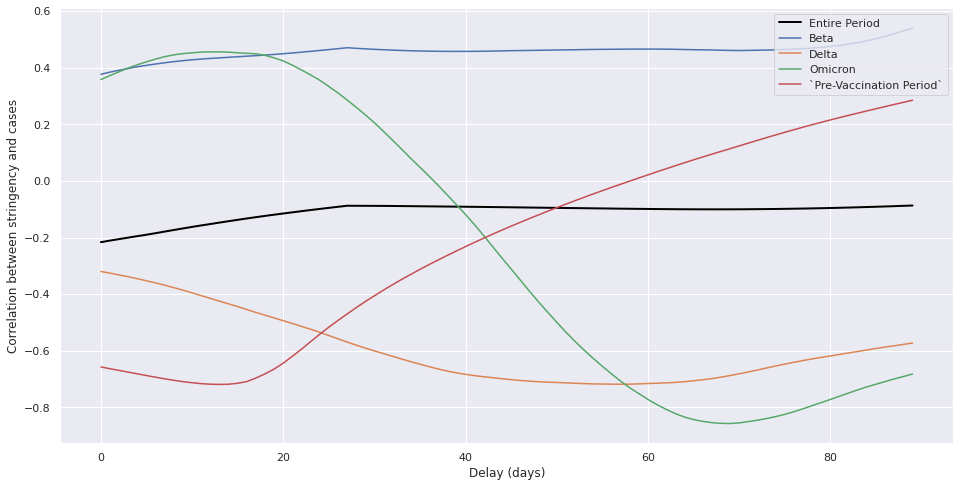

In [38]:
# Cases vs stringency
entire = []
pre_delta = []
delta_omicron = []
omicron = []
prevax = []
for lag in range(90):
    date_mean_df[f'stringency_{lag}'] = date_mean_df['stringency_index'].shift(lag)
    entire.append(date_mean_df['new_cases_smoothed_per_million'].corr(date_mean_df[f'stringency_{lag}']))
    pre_delta.append(date_mean_df[date_mean_df['date'] <= '2020-10-15']['new_cases_smoothed_per_million'].corr(
                    date_mean_df[date_mean_df['date'] <= '2020-10-15'][f'stringency_{lag}']))
    delta_omicron.append(date_mean_df[(date_mean_df['date'] >= '2020-10-15') &\
                                                (date_mean_df['date'] <= '2021-11-15')]['new_cases_smoothed_per_million'].corr(
                                                    date_mean_df[(date_mean_df['date'] >= '2020-10-15') &\
                                                                        (date_mean_df['date'] <= '2021-11-15')][f'stringency_{lag}']))
    omicron.append(date_mean_df[date_mean_df['date'] >= '2021-11-15']['new_cases_smoothed_per_million'].corr(
                    date_mean_df[date_mean_df['date'] >= '2021-11-15'][f'stringency_{lag}']))
    prevax.append(date_mean_df[(date_mean_df['date'] >= '2020-04-01') &\
                                                (date_mean_df['date'] <= '2020-12-31')]['new_cases_smoothed_per_million'].corr(
                                                    date_mean_df[(date_mean_df['date'] >= '2020-04-01') &\
                                                                        (date_mean_df['date'] <= '2020-12-31')][f'stringency_{lag}']))
plt.plot(range(90), entire, label="Entire Period", linewidth=2, color='black')
plt.plot(range(90), pre_delta, label="Beta")
plt.plot(range(90), delta_omicron, label="Delta")
plt.plot(range(90), omicron, label="Omicron")
plt.plot(range(90), prevax, label="`Pre-Vaccination Period`")
plt.legend()
plt.xlabel("Delay (days)")
plt.ylabel("Correlation between stringency and cases")

Compliance grouped by countries before averaging compliance

Afghanistan Albania Algeria Andorra Angola Argentina Aruba Australia Austria Azerbaijan Bahamas Bahrain Bangladesh Barbados Belarus Belgium Belize Benin Bermuda Bhutan Bolivia Bosnia and Herzegovina Botswana Brazil Brunei Bulgaria Burkina Faso Burundi Cambodia Cameroon Canada Cape Verde Central African Republic Chad Chile China Colombia Congo Costa Rica Cote d'Ivoire Croatia Cuba Cyprus Czechia Democratic Republic of Congo Denmark Djibouti Dominica Dominican Republic Ecuador Egypt El Salvador Eritrea Estonia Eswatini Ethiopia Faeroe Islands Fiji Finland France Gabon Gambia Georgia Germany Ghana Greece Greenland Guam Guatemala Guinea Guyana Haiti Honduras Hong Kong Hungary Iceland India Indonesia Iran Iraq Ireland Israel Italy Jamaica Japan Jordan Kazakhstan Kenya Kiribati Kosovo Kuwait Kyrgyzstan Laos Latvia Lebanon Lesotho Liberia Libya Liechtenstein Lithuania Luxembourg Macao Madagascar Malawi Malaysia Mali Malta Mauritania Mauritius Mexico Moldova Monaco Mongolia Morocco Mozambique 

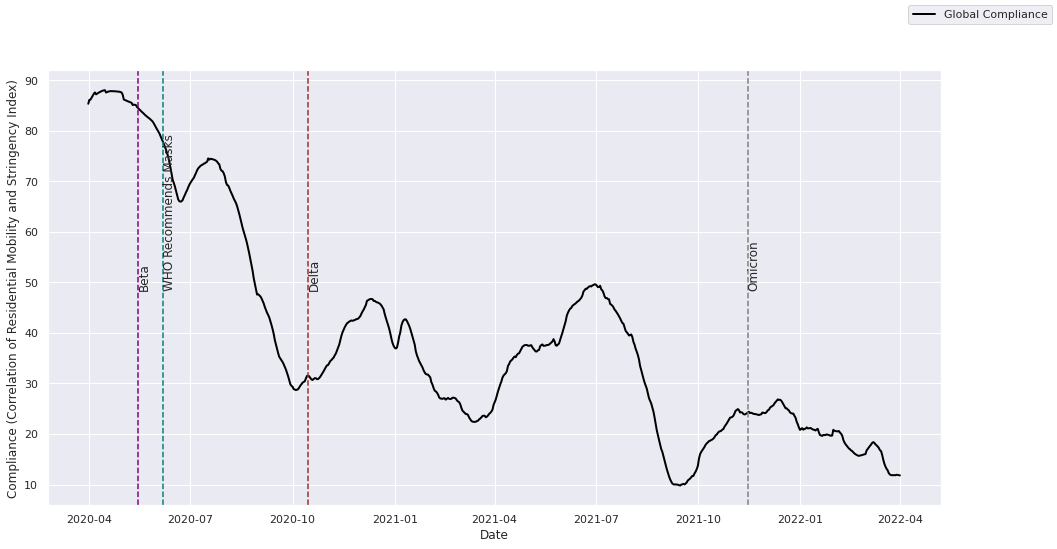

In [39]:
df_for_windows = merged_df[['date', 'country', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 90 # Averaging window of 3 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

date_mean_df = merged_df.groupby('date').agg('mean').reset_index()
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])


df_for_windows = df_for_windows.groupby(['date', 'country']).agg('mean').reset_index()

fig, ax = plt.subplots()

country_compliances_df = pd.DataFrame()
country_compliances_df['date'] = pd.date_range('1/1/2020', '31/3/2022')
country_compliances_df.set_index('date', inplace=True)

for country in df_for_windows['country'].unique():
    residential_corr = []
    end_dates = []
    if country not in ['0', 0]:
        print(country, end=' ') # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        country_compliances_df[country] = [None for i in range(len(country_compliances_df))]
        for window in df_for_windows[df_for_windows['country']==country].rolling(window=rolling_window):
            country_compliances_df.at[window['date'].iloc[0] + timedelta(days=rolling_window), country] = 100 * window[['residential','stringency_index']].corr()['stringency_index'][0]
            
country_compliances_df['average_compliance'] = country_compliances_df.mean(axis=1) # Average across columns
ax.plot(country_compliances_df['average_compliance'], label="Global Compliance", color="black", linewidth=2)

ylim_top, ylim_bottom = ax.get_ylim()

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax.axvline(x='2020-05-15', linestyle='--', color='purple')
ax.text('2020-05-15',(ylim_top+ylim_bottom)/2,'Beta',rotation=90)
ax.axvline(x='2020-10-15', linestyle='--', color='brown')
ax.text('2020-10-15',(ylim_top+ylim_bottom)/2,'Delta',rotation=90)
ax.axvline(x='2021-11-15', linestyle='--', color='gray')
ax.text('2021-11-15',(ylim_top+ylim_bottom)/2,'Omicron',rotation=90)
plt.axvline(x='2020-06-06', linestyle='--', color='teal')
plt.text('2020-06-06',(ylim_top+ylim_bottom)/2,'WHO Recommends Masks',rotation=90)

fig.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Compliance (Correlation of Residential Mobility and Stringency Index)")
plt.show()

North America 0.9579382103914885
South America 0.9390197441700987
Asia 0.9439902154039429
Europe 0.9814186532231227
Oceania 0.8974048099822921
Africa 0.9273953462249602


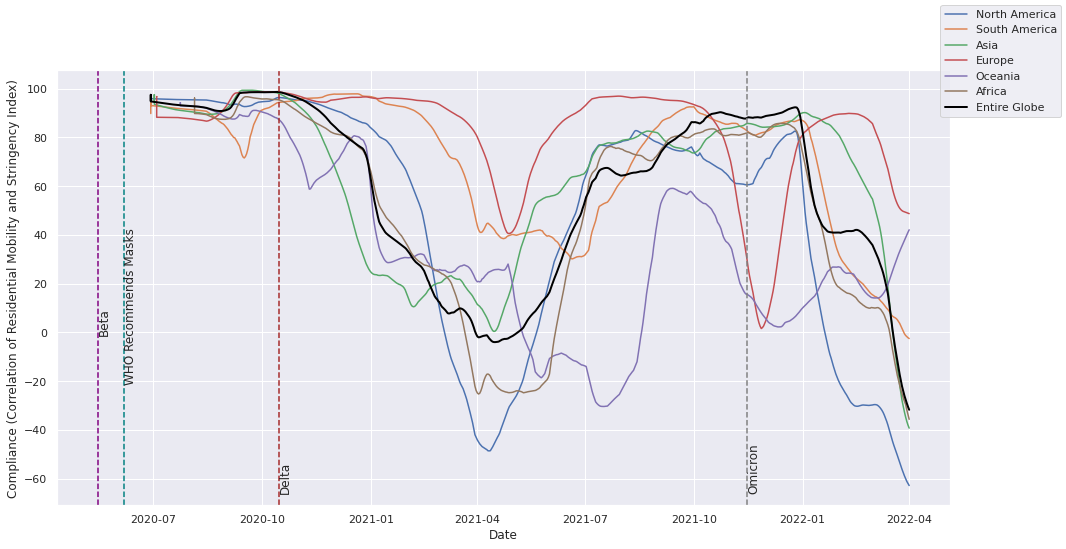

In [40]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 180 # Averaging window of 6 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

date_mean_df = merged_df.groupby('date').agg('mean').reset_index()
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])


df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

fig, ax = plt.subplots()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent, end=' ') # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        for window in df_for_windows[df_for_windows['continent']==continent].rolling(window=rolling_window):
            # if len(window) > 0:
            residential_corr.append(100 * window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(window['date'].iloc[0] + timedelta(days=rolling_window))
        ax.plot(end_dates[panic_window:], residential_corr[panic_window:], label=continent)

        continent_df = df_for_windows[df_for_windows['continent']==continent]
        continent_df = continent_df[continent_df['date'] <= '2020-12-31']
        continent_df = continent_df[continent_df['date'] >= '2020-04-01']
      
        print(continent_df['residential'].corr(continent_df['stringency_index']))
        
residential_corr = []
end_dates = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    residential_corr.append(100 * window[['residential','stringency_index']].corr()['stringency_index'][0])
    end_dates.append(list(window['date'])[0] + timedelta(days=rolling_window))
ax.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Entire Globe", color="black", linewidth=2)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax.axvline(x='2020-05-15', linestyle='--', color='purple')
ax.text('2020-05-15',0,'Beta',rotation=90)
ax.axvline(x='2020-10-15', linestyle='--', color='brown')
ax.text('2020-10-15',-65,'Delta',rotation=90)
ax.axvline(x='2021-11-15', linestyle='--', color='gray')
ax.text('2021-11-15',-65,'Omicron',rotation=90)
plt.axvline(x='2020-06-06', linestyle='--', color='teal')
plt.text('2020-06-06',-20,'WHO Recommends Masks',rotation=90)

fig.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Compliance (Correlation of Residential Mobility and Stringency Index)")
plt.show()

In [41]:
end_dates[0]

Timestamp('2020-06-29 00:00:00')

In [42]:
residential_corr[end_dates.index(datetime(2021, 12, 31))]

85.38006410880132

North America 0.9579382103914885


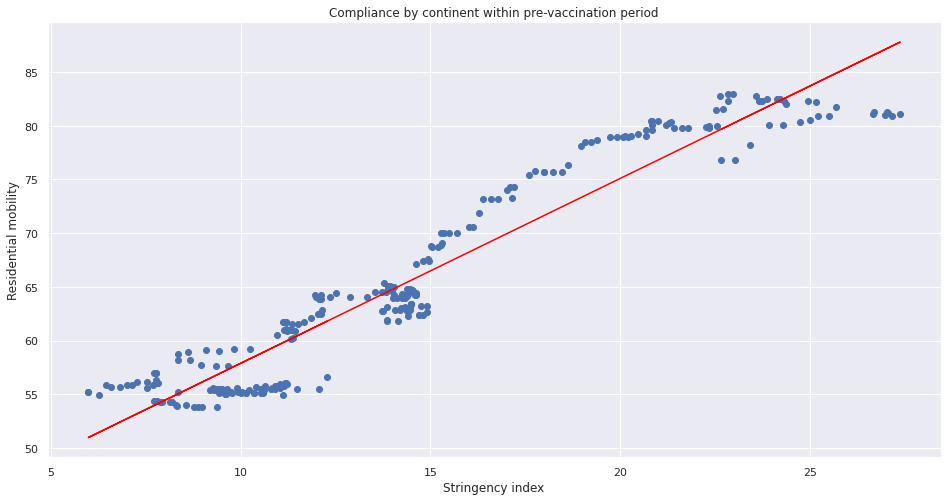

South America 0.9390197441700987


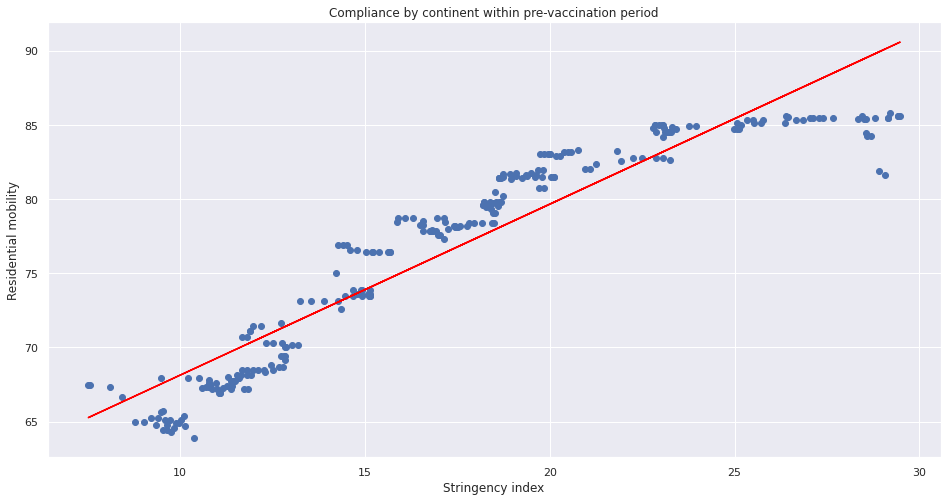

Asia 0.9439902154039429


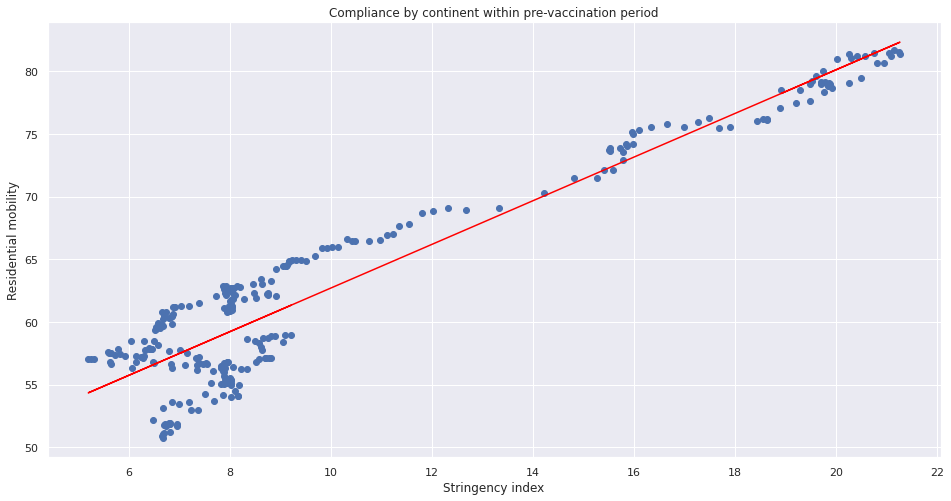

Europe 0.9814186532231227


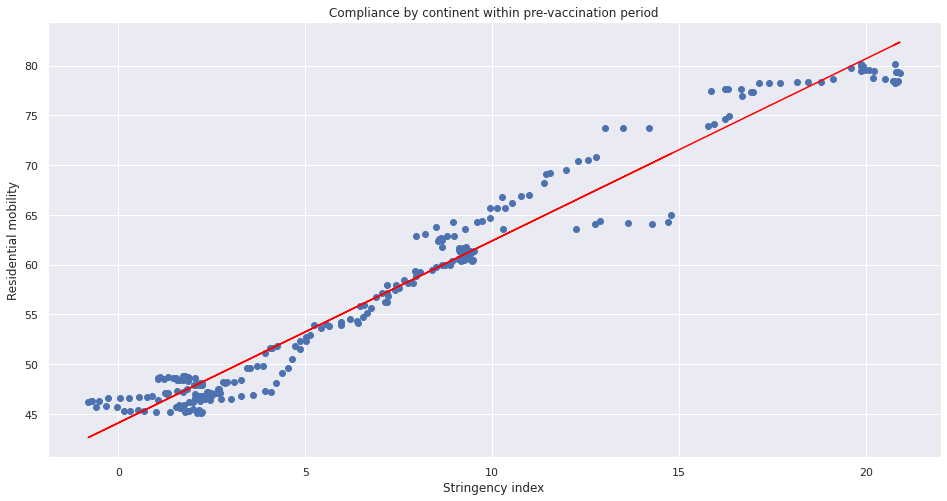

Oceania 0.8974048099822921


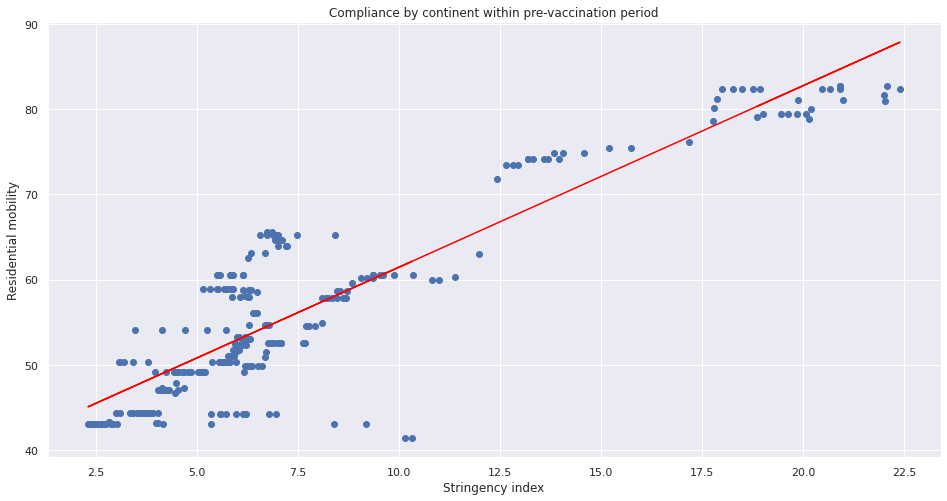

Africa 0.9273953462249602


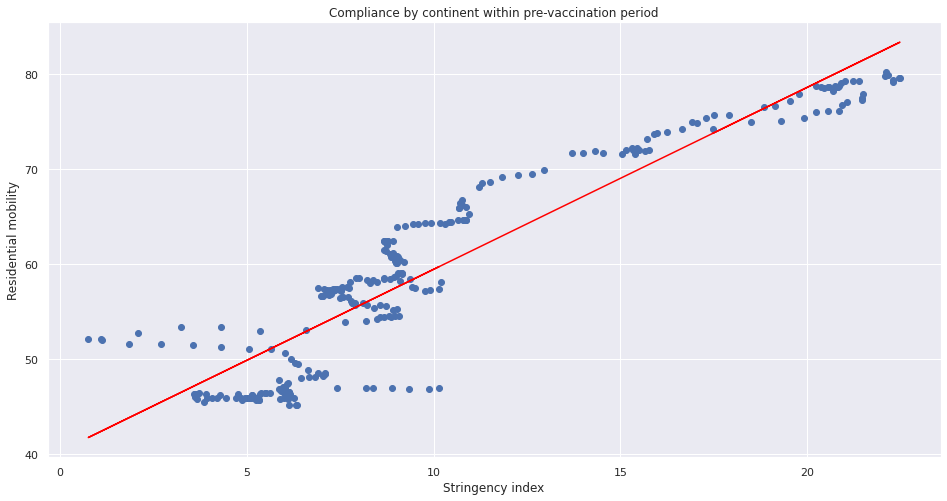

In [43]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

# rolling_window = 180 # Averaging window of 6 months
# panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent, end=' ') # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level

        continent_df = df_for_windows[df_for_windows['continent']==continent]
        continent_df = continent_df[continent_df['date'] <= '2020-12-31']
        continent_df = continent_df[continent_df['date'] >= '2020-04-01']
        print(continent_df['residential'].corr(continent_df['stringency_index']))
        plt.scatter(continent_df['residential'], continent_df['stringency_index'])
        a, b = np.polyfit(continent_df['residential'], continent_df['stringency_index'], 1)
        
        plt.plot(continent_df['residential'], a*continent_df['residential']+b, color='red')
        plt.ylabel("Residential mobility")
        plt.xlabel("Stringency index")
        plt.title("Compliance by continent within pre-vaccination period")
        plt.show()
        

### Q2. Effectiveness of disaggregated measures:
Masks + the 9 stringency sub-indices  

In [44]:
face_coverings_df = pd.read_csv('data/stringency/face_coverings/face-covering-policies-covid.csv')[['Entity', 'Day', 'facial_coverings']]
face_coverings_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
face_coverings_df['date'] = pd.to_datetime(face_coverings_df['date'])
face_coverings_df = face_coverings_df[face_coverings_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, face_coverings_df, on=['country', 'date'], how='left')

In [45]:
lockdowns_df = pd.read_csv('data/stringency/lockdowns/stay-at-home-covid.csv')[['Entity', 'Day', 'stay_home_requirements']]
lockdowns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
lockdowns_df['date'] = pd.to_datetime(lockdowns_df['date'])
lockdowns_df = lockdowns_df[lockdowns_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, lockdowns_df, on=['country', 'date'], how='left')

In [46]:
school_closure_df = pd.read_csv('data/stringency/school_closure/school-closures-covid.csv')[['Entity', 'Day', 'school_closures']]
school_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
school_closure_df['date'] = pd.to_datetime(school_closure_df['date'])
school_closure_df = school_closure_df[school_closure_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, school_closure_df, on=['country', 'date'], how='left')

In [47]:
workplace_closure_df = pd.read_csv('data/stringency/workplace_closure/workplace-closures-covid.csv')[['Entity', 'Day', 'workplace_closures']]
workplace_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
workplace_closure_df['date'] = pd.to_datetime(workplace_closure_df['date'])
workplace_closure_df = workplace_closure_df[workplace_closure_df['date'] < ANALYSIS_END_DATE]

merged_df = pd.merge(merged_df, workplace_closure_df, on=['country', 'date'], how='left')

In [48]:
# Policy Regressions Against Cases
policy_cases_df = merged_df[['date', 'country']+list(merged_df.columns[-4:])+['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'residential', 'new_people_vaccinated_smoothed','population']]

In [49]:
# Pull in stringency sub-indices
# Public event stringency
event_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-events-covid.csv')[['Entity', 'Day', 'cancel_public_events']]
event_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
event_stringency_df['date'] = pd.to_datetime(event_stringency_df['date'])
event_stringency_df = event_stringency_df[event_stringency_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(event_stringency_df, on=['country', 'date'], how='left')

# gathering restrictions
gethering_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-gathering-rules-covid.csv')[['Entity', 'Day', 'restriction_gatherings']]
gethering_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restriction_gatherings":"gathering_restrictions"},
    inplace=True)
gethering_stringency_df['date'] = pd.to_datetime(gethering_stringency_df['date'])
gethering_stringency_df = gethering_stringency_df[gethering_stringency_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(gethering_stringency_df, on=['country', 'date'], how='left')

# public info campaigns
info_campaigns_df = pd.read_csv('data/stringency/information/public-campaigns-covid.csv')[['Entity', 'Day', 'public_information_campaigns']]
info_campaigns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
info_campaigns_df['date'] = pd.to_datetime(info_campaigns_df['date'])
info_campaigns_df = info_campaigns_df[info_campaigns_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(info_campaigns_df, on=['country', 'date'], how='left')

# internal movement restrictions
internal_movement_df = pd.read_csv('data/stringency/movement_restrictions/internal-movement-covid.csv')[['Entity', 'Day', 'restrictions_internal_movements']]
internal_movement_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restrictions_internal_movements":"internal_movement_restrictions"},
    inplace=True)
internal_movement_df['date'] = pd.to_datetime(internal_movement_df['date'])
internal_movement_df = internal_movement_df[internal_movement_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(internal_movement_df, on=['country', 'date'], how='left')

# international travel restrictions
international_travel_df = pd.read_csv('data/stringency/movement_restrictions/international-travel-covid.csv')[['Entity', 'Day', 'international_travel_controls']]
international_travel_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
international_travel_df['date'] = pd.to_datetime(international_travel_df['date'])
international_travel_df = international_travel_df[international_travel_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(international_travel_df, on=['country', 'date'], how='left')

# public transport restrictions
public_transport_df = pd.read_csv('data/stringency/movement_restrictions/public-transport-covid.csv')[['Entity', 'Day', 'close_public_transport']]
public_transport_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
public_transport_df['date'] = pd.to_datetime(public_transport_df['date'])
public_transport_df = public_transport_df[public_transport_df['date'] < ANALYSIS_END_DATE]

policy_cases_df = policy_cases_df.merge(public_transport_df, on=['country', 'date'], how='left')

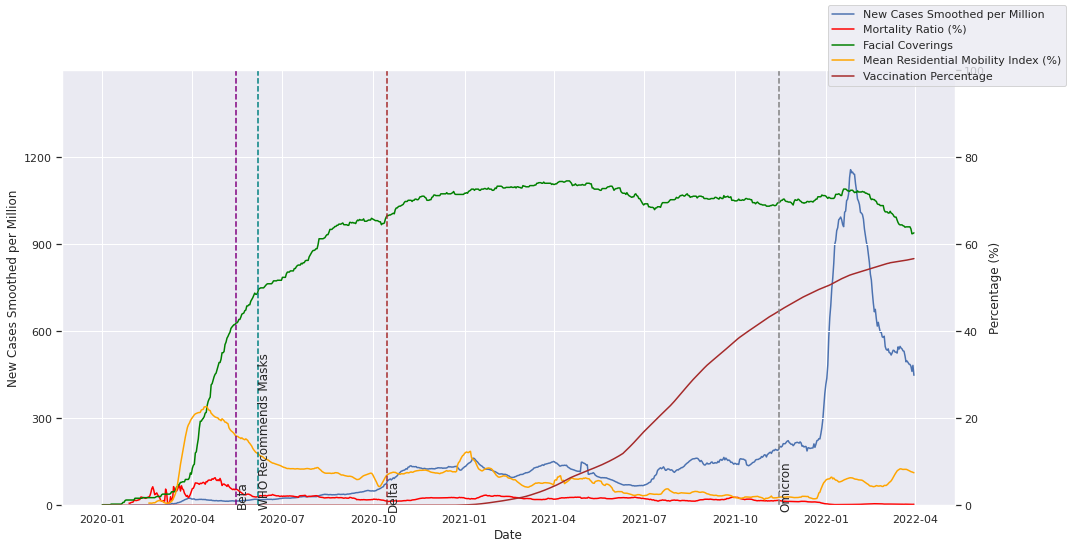

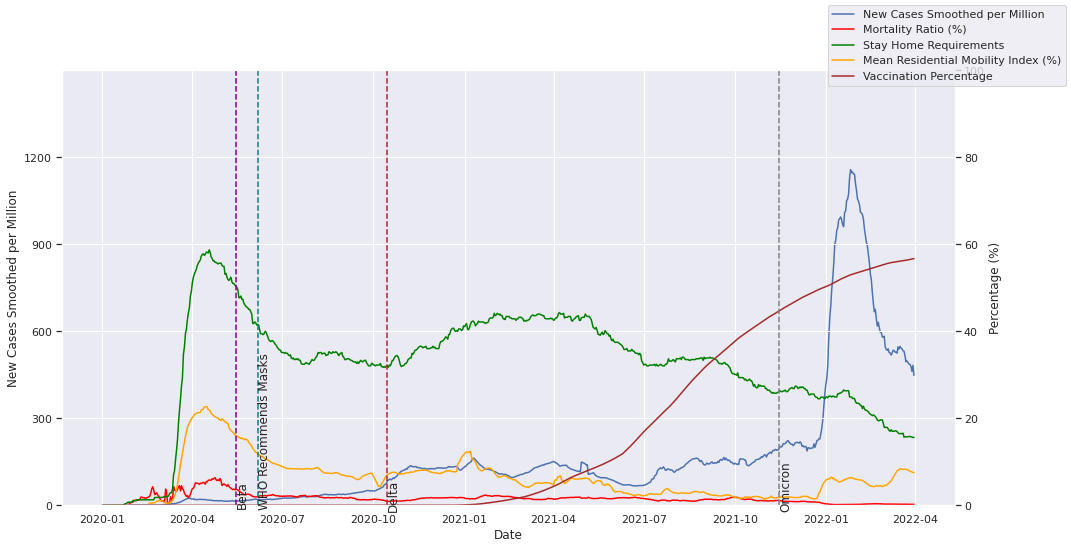

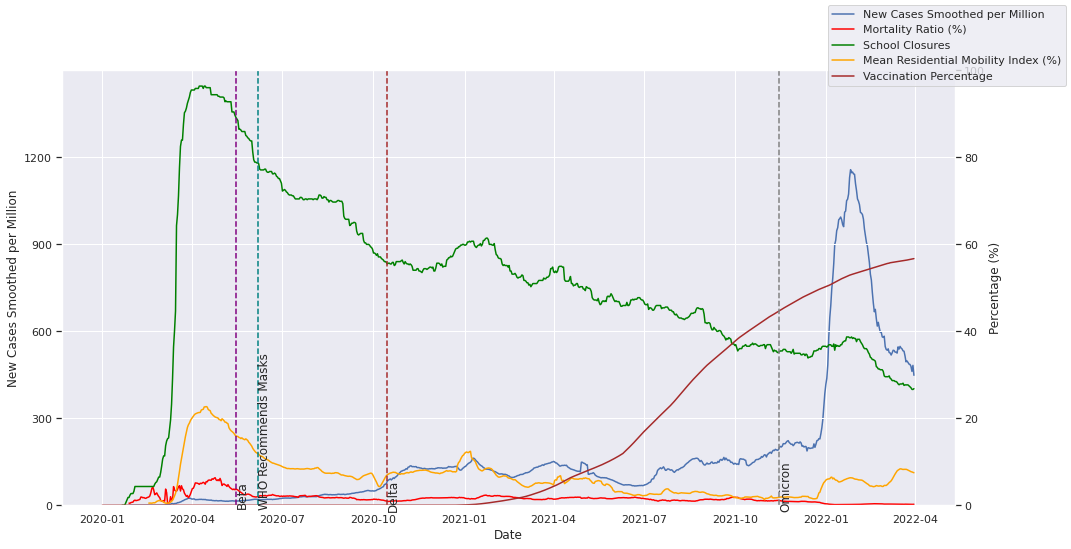

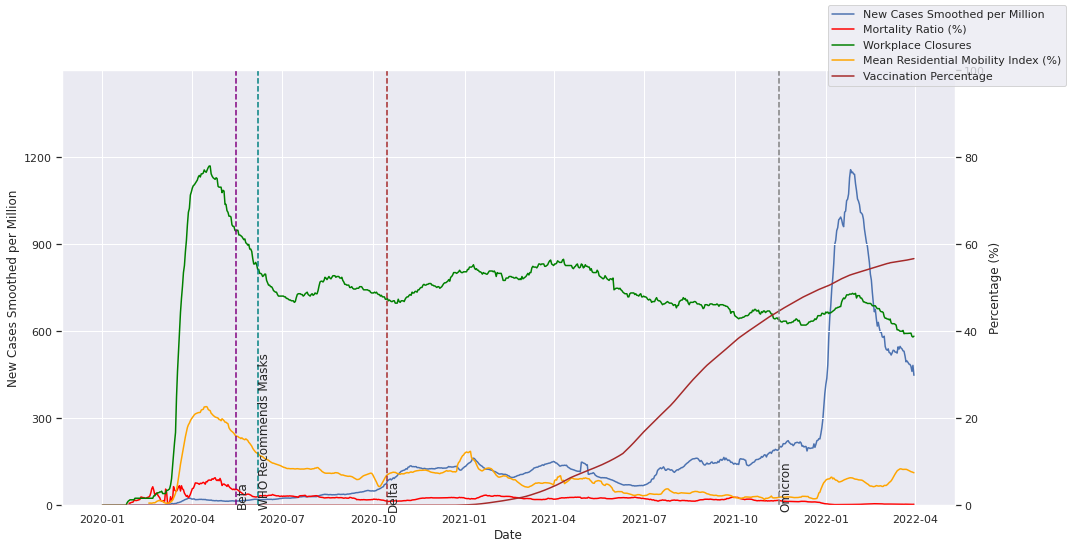

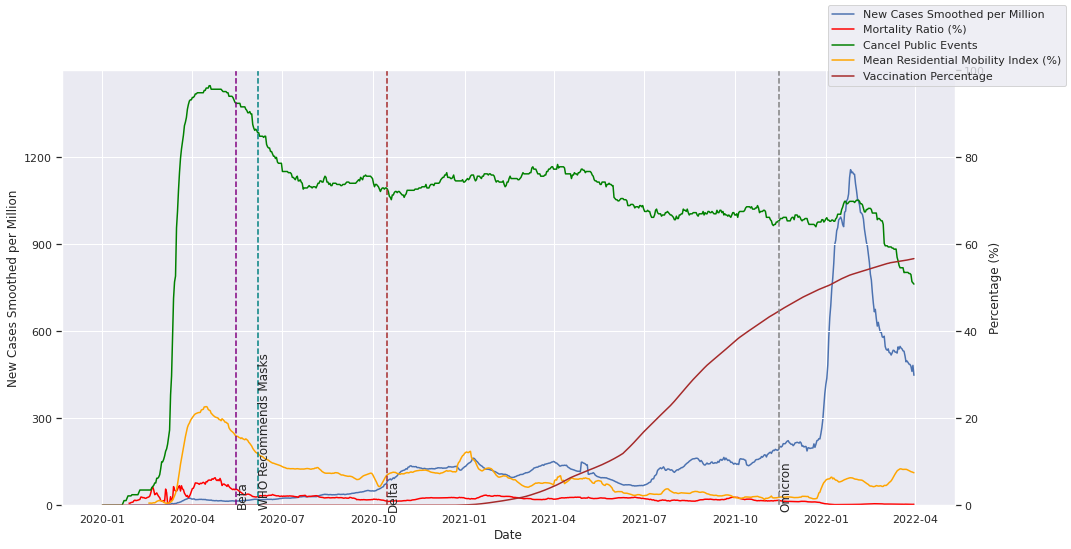

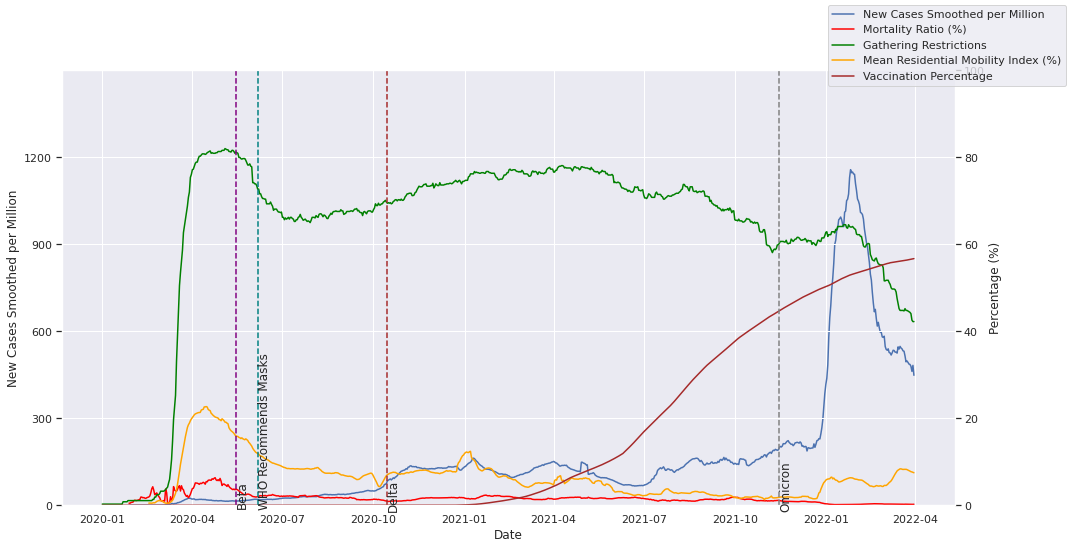

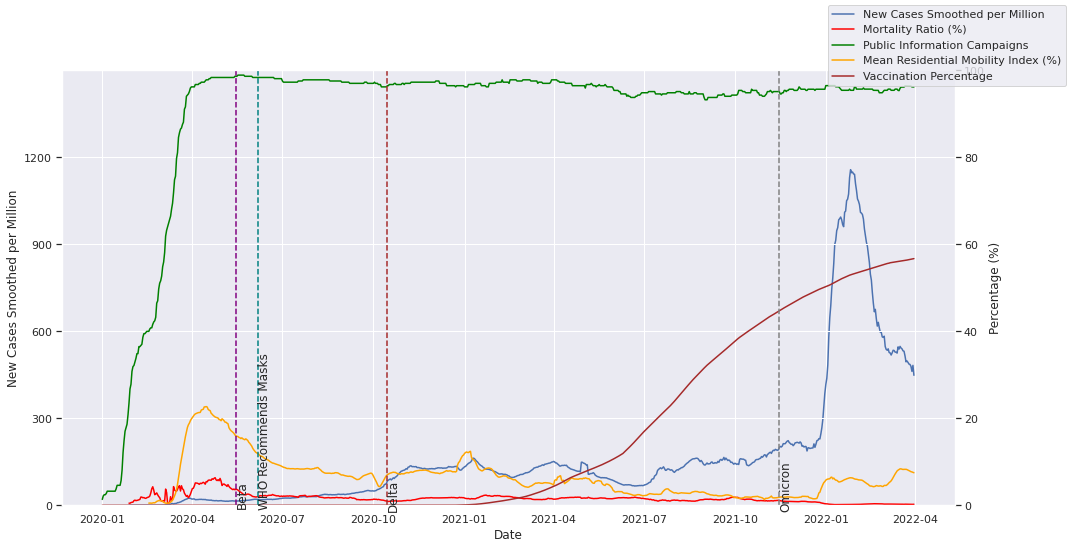

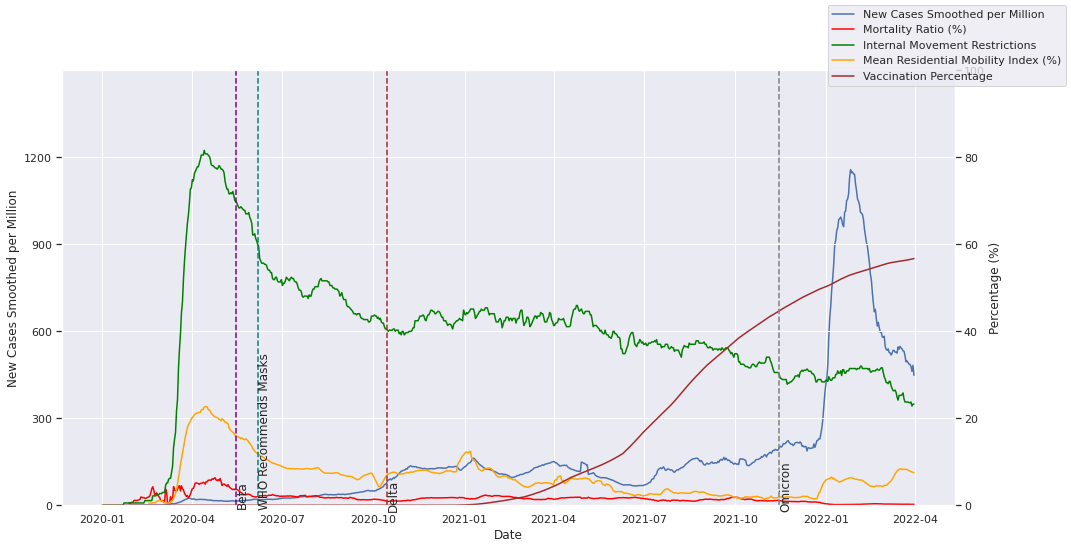

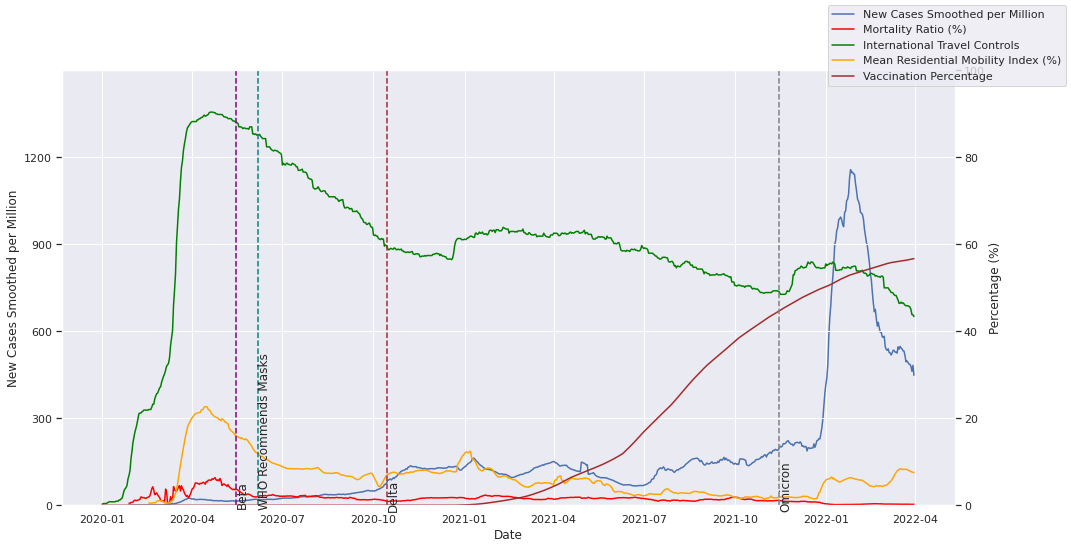

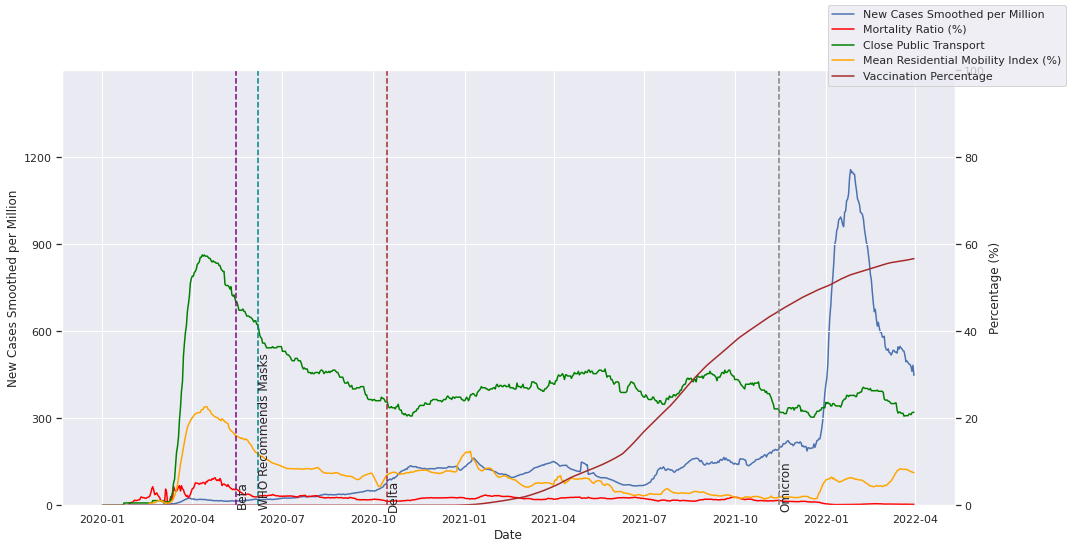

In [50]:
feature_correlations = {} # for bar graph for report

for feature in policy_cases_df.columns:
    if feature in ['date', 'country', 'new_cases_smoothed_per_million',
        'new_deaths_smoothed_per_million', 'residential', 
        'new_people_vaccinated_smoothed', 'population']\
        or "cases" in feature:
        continue
    policy_cases_df[feature] = 100 * policy_cases_df[feature]/max(policy_cases_df[feature])
    # Sum features need to be summed in aggregation
    # Others need to be averaged in aggregation
    date_sum_df = policy_cases_df.groupby('date').agg('sum').reset_index()
    date_mean_df = policy_cases_df.groupby('date').agg('mean').reset_index()

    date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
    date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

    fig, ax = plt.subplots()

    # Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
    ax.plot(date_mean_df['date'], date_mean_df['new_cases_smoothed_per_million'], label='New Cases Smoothed per Million')
    ax.set_ylabel('New Cases Smoothed per Million')
    ax.set_xlabel('Date')
    feature_correlations[feature] = policy_cases_df[feature].corr(policy_cases_df['new_cases_smoothed_per_million'])

    # Mortality ratio (Derived from cases and deaths) - how deadly is it?
    ax_twin_percentages = ax.twinx()
    ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
    ax_twin_percentages.set_ylabel('Percentage (%)')

    # Stringency over time  - how are governments responding?
    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df[feature], label=space_and_title_case(feature), color='green')

    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

    ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

    ax.set_ylim(0, 1500)
    ax.yaxis.set_ticks(np.arange(0, 1500, 300))
    ax_twin_percentages.set_ylim(0, 100)

    # Variant lines. Dates the variants were declared variants of concern.
    # Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/

    ax_twin_percentages.axvline(x='2020-05-15', linestyle='--', color='purple')
    ax_twin_percentages.text('2020-05-15',0,'Beta',rotation=90)
    ax_twin_percentages.axvline(x='2020-10-15', linestyle='--', color='brown')
    ax_twin_percentages.text('2020-10-15',-0.65,'Delta',rotation=90)
    ax_twin_percentages.axvline(x='2021-11-15', linestyle='--', color='gray')
    ax_twin_percentages.text('2021-11-15',-0.65,'Omicron',rotation=90)
    ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
    ax_twin_percentages.text('2020-06-06',-0.2,'WHO Recommends Masks',rotation=90)

    fig.legend()
    plt.show()

Combine Sub-indices int one graph

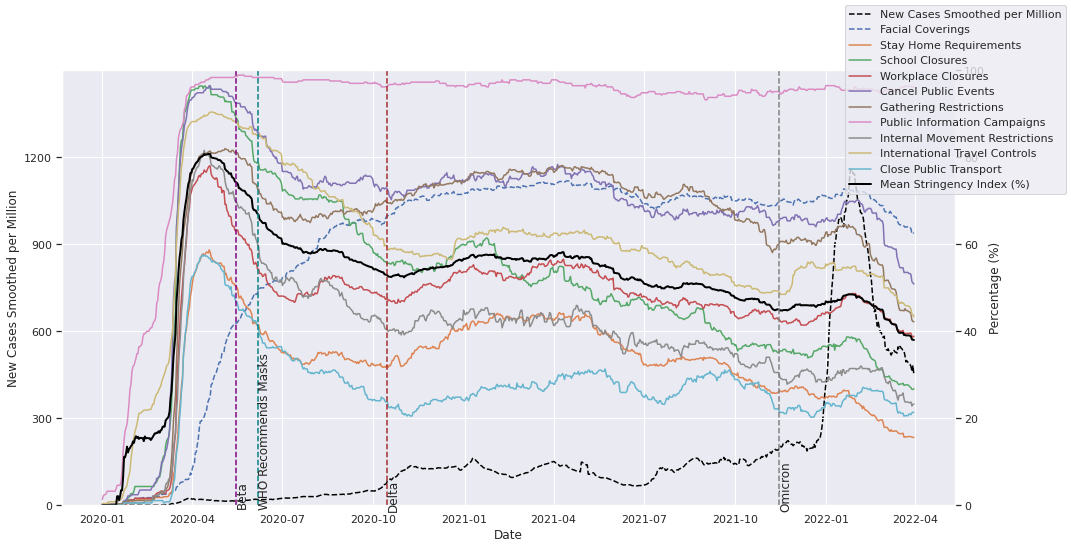

In [51]:
fig, ax = plt.subplots()
ax_twin_percentages = ax.twinx()

# Sum features need to be summed in aggregation
# Others need to be averaged in aggregation
date_sum_df = policy_cases_df.groupby('date').agg('sum').reset_index()
date_mean_df = policy_cases_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

# Mean of new cases smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_cases_smoothed_per_million'], label='New Cases Smoothed per Million', linestyle='--', color='black')
ax.set_ylabel('New Cases Smoothed per Million')
ax.set_xlabel('Date')

for feature in policy_cases_df.columns:
    if feature in ['date', 'country', 'new_cases_smoothed_per_million',
        'new_deaths_smoothed_per_million', 'residential', 
        'new_people_vaccinated_smoothed', 'population']\
        or "cases" in feature:
        continue
    policy_cases_df[feature] = 100 * policy_cases_df[feature]/max(policy_cases_df[feature])
    
    # Mortality ratio (Derived from cases and deaths) - how deadly is it?
    # ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
    ax_twin_percentages.set_ylabel('Percentage (%)')

    # Stringency over time  - how are governments responding?
    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df[feature], label=space_and_title_case(feature), linestyle='--' if feature == 'facial_coverings' else '-')

ax_twin_percentages.plot(global_dates, global_stringency, label='Mean Stringency Index (%)', color='black', linewidth=2)

ax.set_ylim(0, 1500)
ax.yaxis.set_ticks(np.arange(0, 1500, 300))
ax_twin_percentages.set_ylim(0, 100)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax_twin_percentages.axvline(x='2020-05-15', linestyle='--', color='purple')
ax_twin_percentages.text('2020-05-15',0,'Beta',rotation=90)
ax_twin_percentages.axvline(x='2020-10-15', linestyle='--', color='brown')
ax_twin_percentages.text('2020-10-15',-0.65,'Delta',rotation=90)
ax_twin_percentages.axvline(x='2021-11-15', linestyle='--', color='gray')
ax_twin_percentages.text('2021-11-15',-0.65,'Omicron',rotation=90)
ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
ax_twin_percentages.text('2020-06-06',-0.2,'WHO Recommends Masks',rotation=90)

fig.legend()
plt.show()

In [52]:
date_mean_df[date_mean_df['date']=='2021-12-31']['new_cases_smoothed_per_million']

730    386.207498
Name: new_cases_smoothed_per_million, dtype: float64

Text(0, 0.5, 'Correlation with New Cases Smoothed per Million')

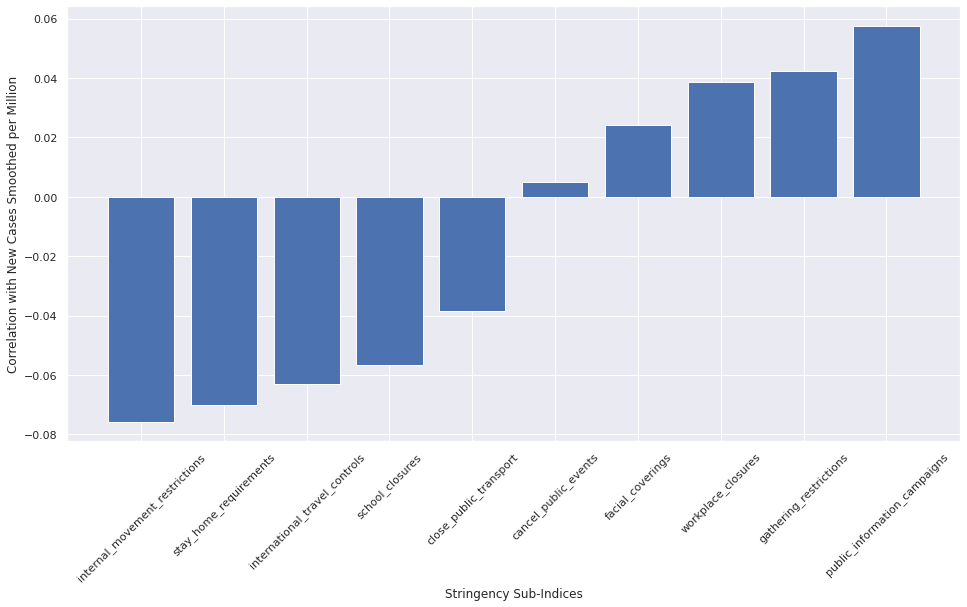

In [53]:
feature_correlations = dict(sorted(feature_correlations.items(), key=lambda item: item[1]))
plt.bar(list(feature_correlations.keys()), list(feature_correlations.values()))
plt.xticks(rotation = 45)
plt.xlabel('Stringency Sub-Indices')
plt.ylabel('Correlation with New Cases Smoothed per Million')

Text(0.5, 1.0, 'Correlations between Stringency Sub-Indices and New Case Counts for Varying Delays')

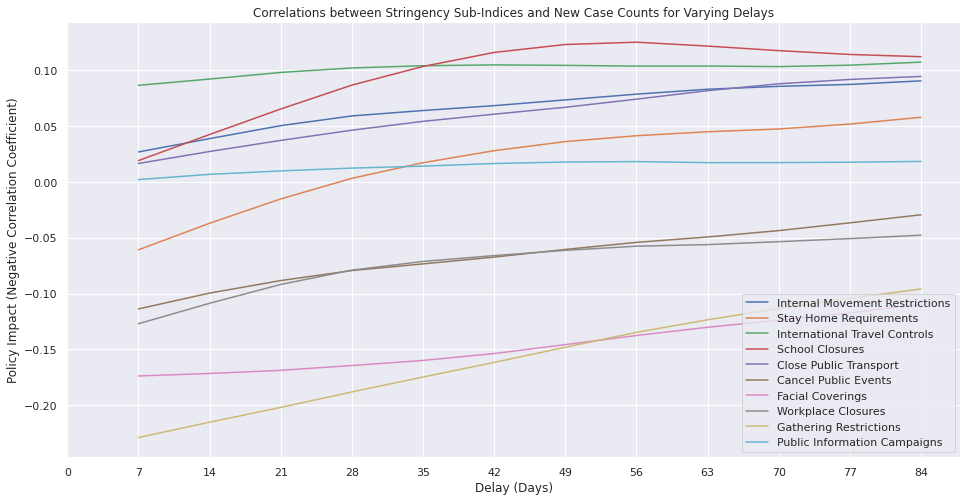

In [54]:
# get changes in cases as an alternate y variable
policy_cases_df['date'] = pd.to_datetime(policy_cases_df['date'])
# policy_cases_df["cases_changes"] = policy_cases_df.groupby('country')['new_cases_smoothed_per_million'].diff()

copy_df = policy_cases_df.copy()

# implement lags
for lag in [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]:
    copy_df[f"cases_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].shift(-lag)

temp_df = copy_df[copy_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
for policy in feature_correlations.keys():
    line = []
    for lag in [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]:
        line.append(-1*temp_df[f"cases_lag_{lag}"].corr(temp_df[policy]))
    plt.plot([7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84],line, label=space_and_title_case(policy))
plt.legend()
plt.xticks([0,7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84])
plt.ylabel("Policy Impact (Negative Correlation Coefficient)")
plt.xlabel("Delay (Days)")
plt.title("Correlations between Stringency Sub-Indices and New Case Counts for Varying Delays")

Text(0.5, 1.0, 'Correlations between Stringency Sub-Indices and Difference in Case Counts for Varying Time Periods')

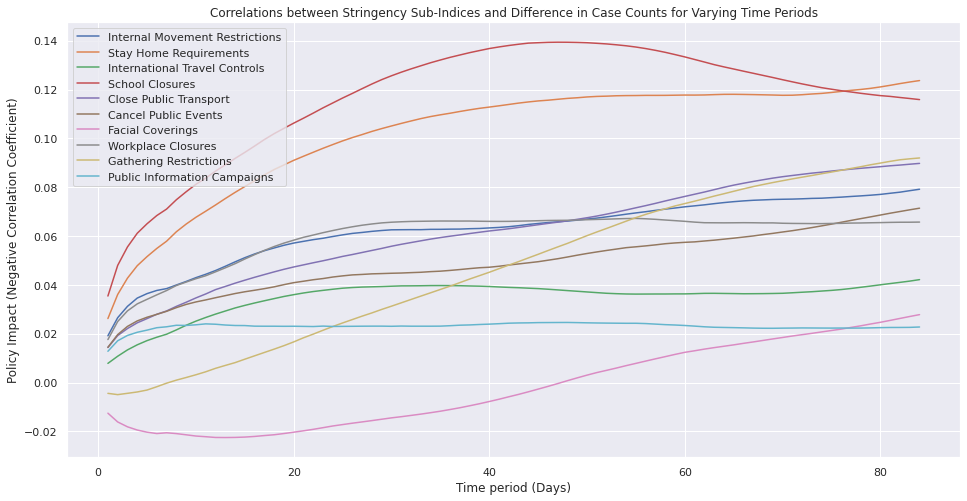

In [55]:
copy_df = policy_cases_df.copy()

for lag in range(85):
    copy_df[f"cases_changes_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].diff(lag).shift(-lag)
temp_df = copy_df[copy_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
for policy in feature_correlations.keys():
    line = []
    for lag in range(85):
        line.append(-1*temp_df[f"cases_changes_lag_{lag}"].corr(temp_df[policy]))
    plt.plot(list(range(85)),line, label=space_and_title_case(policy))
plt.legend()
plt.ylabel("Policy Impact (Negative Correlation Coefficient)")
plt.xlabel("Time period (Days)")
plt.title("Correlations between Stringency Sub-Indices and Difference in Case Counts for Varying Time Periods")


internal_movement_restrictions 1.950975428535801 25
stay_home_requirements 3.0078372601131695 26
international_travel_controls -0.10940632734406233 1
school_closures 2.0070515392986916 25
close_public_transport 0.9594158649080389 12
cancel_public_events 3.3404146732990805 23
facial_coverings 8.66282585218586 31
workplace_closures 4.52367504483429 25
gathering_restrictions 5.764334761605106 12
public_information_campaigns 0.02239182313834514 49


Text(0.5, 0, 'Horizon (Days)')

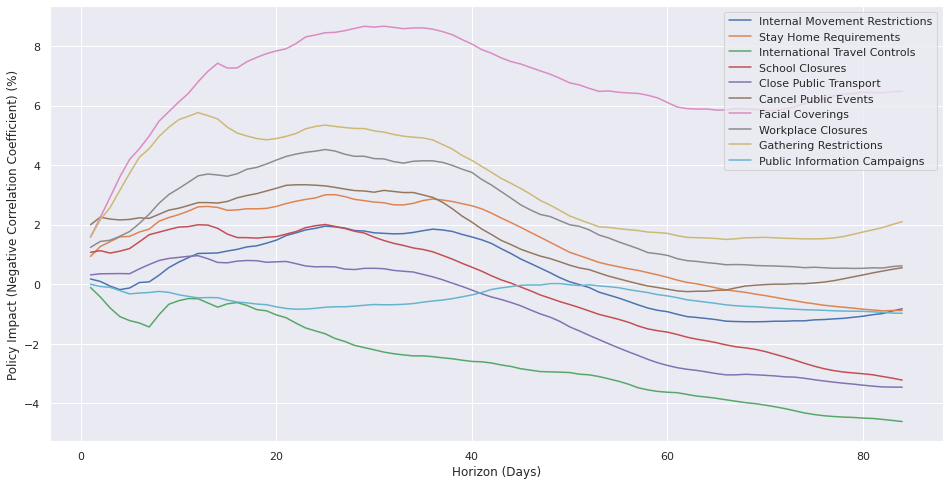

In [56]:
copy_df = policy_cases_df.copy()

for lag in range(85):
    copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(lag).shift(-lag)
    # copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].diff(lag).shift(-lag)
    # copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df[f"cases_changes_pct_lag_{lag}"]/copy_df['new_cases_smoothed_per_million']
    copy_df[f"cases_changes_pct_lag_{lag}"].replace([np.inf, -np.inf], np.nan, inplace=True)

temp_df = copy_df[copy_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
for policy in feature_correlations.keys():
    line = []
    for lag in range(85):
        line.append(-100 * temp_df[f"cases_changes_pct_lag_{lag}"].corr(temp_df[policy]))
    print(policy, np.nanmax(line), line.index(np.nanmax(line)))
    plt.plot(list(range(85)),line, label=space_and_title_case(policy))
plt.legend()
plt.ylabel("Policy Impact (Negative Correlation Coefficient) (%)")
plt.xlabel("Horizon (Days)")
# plt.title("Correlations between Stringency Sub-Indices and Percentage Changes in Case Counts for Varying Time Periods")


Text(0.5, 1.0, 'Correlations between Percentage Change in Stringency Sub-Indices (Varying d) and Percentage Change in Case Counts (over k= 20 Days)')

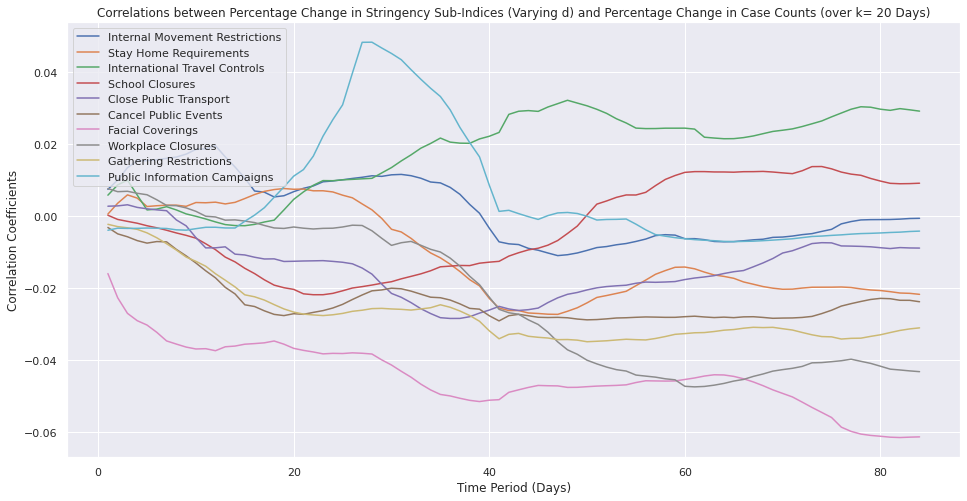

In [57]:
copy_df = policy_cases_df.copy()

copy_df[f"cases_changes_pct_lag_{20}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(20).shift(-20)
# copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].diff(lag).shift(-lag)
# copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df[f"cases_changes_pct_lag_{lag}"]/copy_df['new_cases_smoothed_per_million']
copy_df[f"cases_changes_pct_lag_{20}"].replace([np.inf, -np.inf], np.nan, inplace=True)

temp_df = copy_df[copy_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
for policy in feature_correlations.keys():
    line = []
    for d in range(85):
        pct_changes = temp_df[policy].pct_change(d)
        pct_changes.replace([np.inf, -np.inf], np.nan, inplace=True)
        line.append(temp_df[f"cases_changes_pct_lag_{20}"].corr(pct_changes))
    line = pd.Series(line)
    plt.plot(line, label=space_and_title_case(policy))
plt.legend()
plt.ylabel("Correlation Coefficients")
plt.xlabel("Time Period (Days)")
plt.title("Correlations between Percentage Change in Stringency Sub-Indices (Varying d) and Percentage Change in Case Counts (over k= 20 Days)")


Text(0.5, 1.0, 'Correlations between Smoothed Stringency Sub-Indices (Varying window sizes) and Percentage Change in Case Counts (over k= 20 Days)')

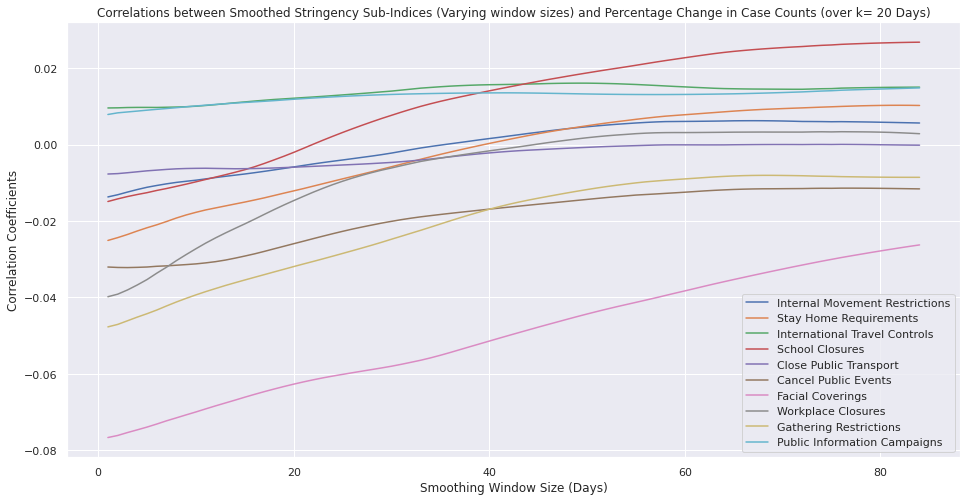

In [58]:
copy_df = policy_cases_df.copy()

copy_df[f"cases_changes_pct_lag_{20}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(20).shift(-20)
# copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].diff(lag).shift(-lag)
# copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df[f"cases_changes_pct_lag_{lag}"]/copy_df['new_cases_smoothed_per_million']
copy_df[f"cases_changes_pct_lag_{20}"].replace([np.inf, -np.inf], np.nan, inplace=True)

temp_df = copy_df[copy_df['date'] <= '2020-12-31']
temp_df = temp_df[temp_df['date'] >= '2020-04-01']
for policy in feature_correlations.keys():
    line = []
    for d in range(85):
        smoothed_policies = temp_df[policy].rolling(d).mean().shift(-d)
        # pct_changes.replace([np.inf, -np.inf], np.nan, inplace=True)
        line.append(temp_df[f"cases_changes_pct_lag_{20}"].corr(smoothed_policies))
    line = pd.Series(line)
    plt.plot(line, label=space_and_title_case(policy))
plt.legend()
plt.ylabel("Correlation Coefficients")
plt.xlabel("Smoothing Window Size (Days)")
plt.title("Correlations between Smoothed Stringency Sub-Indices (Varying window sizes) and Percentage Change in Case Counts (over k= 20 Days)")


Adj. R-Squareds for different horizons

Horizon: 0, Adjusted R-Squared: nan
Backward included: ['facial_coverings', 'stay_home_requirements', 'school_closures', 'workplace_closures', 'cancel_public_events', 'gathering_restrictions', 'public_information_campaigns', 'internal_movement_restrictions', 'international_travel_controls', 'close_public_transport']
Horizon: 1, Adjusted R-Squared: 0.0005293928177791951
Backward included: ['facial_coverings', 'cancel_public_events']
Horizon: 2, Adjusted R-Squared: 0.0009466510307931664
Backward included: ['facial_coverings', 'cancel_public_events', 'internal_movement_restrictions']
Horizon: 3, Adjusted R-Squared: 0.0015723961955984578
Backward included: ['facial_coverings', 'stay_home_requirements', 'cancel_public_events', 'gathering_restrictions', 'public_information_campaigns', 'internal_movement_restrictions']
Horizon: 4, Adjusted R-Squared: 0.002263892855167926
Backward included: ['facial_coverings', 'stay_home_requirements', 'gathering_restrictions', 'public_information_campaigns',

Text(0.5, 1.0, 'Adjusted R-Squared Values for Varying Horizons | Max R-Squared: 0.01 at Horizon: 29')

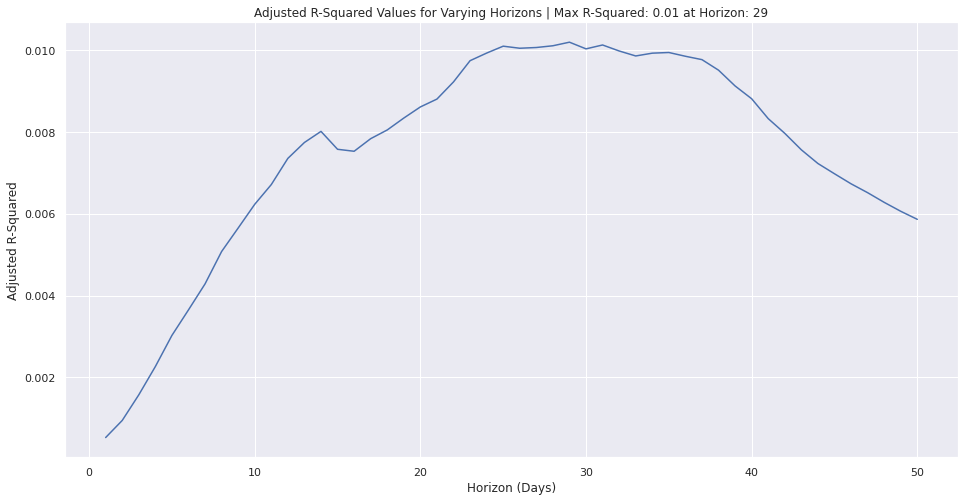

In [59]:
horizon_adj_rsquareds = []
max_adj_rsquared = 0
max_idx = None
for lag in range(51):
    copy_df = policy_cases_df.copy()
    copy_df[f"cases_changes_pct_lag_{lag}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(lag).shift(-lag)
    copy_df[f"cases_changes_pct_lag_{lag}"].replace([np.inf, -np.inf], np.nan, inplace=True)
    copy_df = copy_df[copy_df['date'] <= '2020-12-31']
    copy_df = copy_df[copy_df['date'] >= '2020-04-01']
    X, y = feature_engineering(copy_df, f"cases_changes_pct_lag_{lag}", add_logs=False, add_squares=False, 
                                drop_features=['date', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
                                                'new_people_vaccinated_smoothed', 'residential', 'population'])

    # Run backward stepwise regressions
    backward_included = backward_regression(X, y)
    adj_rsquared = sm.OLS(y, sm.add_constant(X[backward_included])).fit().rsquared_adj
    if adj_rsquared > max_adj_rsquared:
        max_adj_rsquared = adj_rsquared
        max_idx = lag
    print(f"Horizon: {lag}, Adjusted R-Squared: {adj_rsquared}")
    print(f"Backward included: {backward_included}")
    horizon_adj_rsquareds.append(adj_rsquared)

plt.plot(horizon_adj_rsquareds)
plt.ylabel("Adjusted R-Squared")
plt.xlabel("Horizon (Days)")
plt.title(f"Adjusted R-Squared Values for Varying Horizons | Max R-Squared: {round(max_adj_rsquared, 3)} at Horizon: {max_idx}")


In [60]:
copy_df = policy_cases_df.copy()
copy_df[f"cases_changes_pct_lag_{29}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(29).shift(-29)
copy_df[f"cases_changes_pct_lag_{29}"].replace([np.inf, -np.inf], np.nan, inplace=True)
copy_df = copy_df[copy_df['date'] <= '2020-12-31']
copy_df = copy_df[copy_df['date'] >= '2020-04-01']
X, y = feature_engineering(copy_df, f"cases_changes_pct_lag_{29}", add_logs=False, add_squares=False, 
                            drop_features=['date', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
                                            'new_people_vaccinated_smoothed', 'residential', 'population'])
print("Before feature selection:")
print(sm.OLS(y, sm.add_constant(X)).fit().summary())

print("="*20)
print("After feature selection:")
# Run backward stepwise regressions
backward_included = backward_regression(X, y)
print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())

Before feature selection:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     49.28
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           5.24e-99
Time:                        10:14:11   Log-Likelihood:            -1.8833e+05
No. Observations:               46797   AIC:                         3.767e+05
Df Residuals:                   46786   BIC:                         3.768e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [61]:
continent_dict = {}
for continent, group in merged_df.groupby('continent'):
    print(continent) # Print continent
    continent_dict[continent] = set(group['country']) # Get set of countries in continent
    # print(policy_cases_df.columns)
    copy_df = policy_cases_df.copy()
    copy_df[f"cases_changes_pct_lag_{29}"] = copy_df.groupby('country')['new_cases_smoothed_per_million'].pct_change(29).shift(-29)
    copy_df[f"cases_changes_pct_lag_{29}"].replace([np.inf, -np.inf], np.nan, inplace=True)
    copy_df = copy_df[copy_df['date'] <= '2020-12-31']
    copy_df = copy_df[copy_df['date'] >= '2020-04-01']
    X, y = feature_engineering(copy_df[copy_df['country'].isin(continent_dict[continent])],  f"cases_changes_pct_lag_{29}", add_logs=False, add_squares=False, 
                                drop_features=['date', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
                                                'new_people_vaccinated_smoothed', 'residential', 'population'])
    # Run backward stepwise regressions
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print("-"*20, "\n")



Africa
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     48.38
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           2.70e-68
Time:                        10:14:12   Log-Likelihood:                -53721.
No. Observations:               13031   AIC:                         1.075e+05
Df Residuals:                   13023   BIC:                         1.075e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const

In [62]:
policy_cases_df = policy_cases_df[policy_cases_df['date'] <= '2020-12-31']
policy_cases_df = policy_cases_df[policy_cases_df['date'] >= '2020-04-01']

<AxesSubplot:>

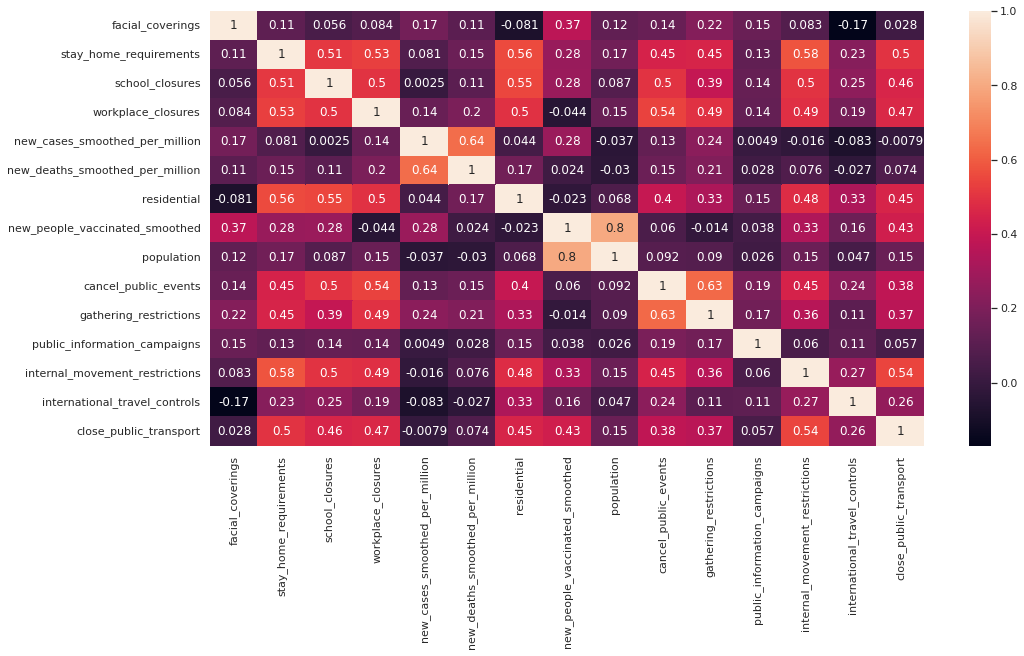

In [63]:
# correlations
sns.heatmap(policy_cases_df[policy_cases_df.columns[2:]].corr(), annot=True)

In [64]:
def insample_rsquared(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    lr_preds = lr.predict(X)
    return r2_score(y, lr_preds)

In [65]:
X, y = feature_engineering(policy_cases_df, 'new_cases_smoothed_per_million', 
                            drop_features=[#'cases_changes', 
                                'date', 'new_people_vaccinated_smoothed', 'population', 'new_deaths_smoothed_per_million', 'residential']#+\
                                # [f"cases_lag_{lag}" for lag in (7,14,21,28)],
                            ,add_logs=False, add_squares=False)

Baseline regression

In [66]:
# check for infs
X.index[np.isinf(X).any(1)]

Int64Index([], dtype='int64')

In [67]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     583.3
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:14:17   Log-Likelihood:            -3.0270e+05
No. Observations:               48604   AIC:                         6.054e+05
Df Residuals:                   48593   BIC:                         6.055e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.2357      4.972      8.092      0.000      30.490      49.982
facial_coverings                   0.4938      0.018     27.464      0.000       0.459       0.529
stay_home_requirements             0.2361      0.026      9.159      0.000       0.186       0.287
school_closures                   -0.2551      0.023    -10.971      0.000      -0.301      -0.210
workplace_closures                 0.5427      0.025     21.475      0.000       0.493       0.592
cancel_public_events               0.0967      0.024      3.994      0.000       0.049       0.144
gathering_restrictions             0.8915      0.023     38.154      0.000       0.846       0.937
public_information_campaigns      -0.5894      0.052    -11.439      0.000      -0.690      -0.488
internal_movement_restrictions    -0.3541      0.017    -20.257      0.000      -0.388      -0.320
international_travel_controls     -0.3046      0.023    -13.237      0.000      -0.350      -0.259
close_public_transport            -0.2264      0.019    -11.839      0.000      -0.264      -0.189
==============================================================================
Omnibus:                    41171.237   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1178257.083
Skew:                           4.058   Prob(JB):                         0.00
Kurtosis:                      25.714   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [69]:
print(forward_included)
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

['gathering_restrictions', 'facial_coverings', 'internal_movement_restrictions', 'workplace_closures', 'international_travel_controls', 'close_public_transport', 'public_information_campaigns', 'school_closures', 'stay_home_requirements', 'cancel_public_events']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     583.3
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:14:20   Log-Likelihood:            -3.0270e+05
No. Observations:               48604   AIC:                         6.054e+05
Df Residuals:                   48593   BIC:                         6.055e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.2357      4.972      8.092      0.000      30.490      49.982
gathering_restrictions             0.8915      0.023     38.154      0.000       0.846       0.937
facial_coverings                   0.4938      0.018     27.464      0.000       0.459       0.529
internal_movement_restrictions    -0.3541      0.017    -20.257      0.000      -0.388      -0.320
workplace_closures                 0.5427      0.025     21.475      0.000       0.493       0.592
international_travel_controls     -0.3046      0.023    -13.237      0.000      -0.350      -0.259
close_public_transport            -0.2264      0.019    -11.839      0.000      -0.264      -0.189
public_information_campaigns      -0.5894      0.052    -11.439      0.000      -0.690      -0.488
school_closures                   -0.2551      0.023    -10.971      0.000      -0.301      -0.210
stay_home_requirements             0.2361      0.026      9.159      0.000       0.186       0.287
cancel_public_events               0.0967      0.024      3.994      0.000       0.049       0.144
==============================================================================
Omnibus:                    41171.237   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1178257.083
Skew:                           4.058   Prob(JB):                         0.00
Kurtosis:                      25.714   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
print(backward_included)
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

['facial_coverings', 'stay_home_requirements', 'school_closures', 'workplace_closures', 'cancel_public_events', 'gathering_restrictions', 'public_information_campaigns', 'internal_movement_restrictions', 'international_travel_controls', 'close_public_transport']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     583.3
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:14:21   Log-Likelihood:            -3.0270e+05
No. Observations:               48604   AIC:                         6.054e+05
Df Residuals:                   48593   BIC:                         6.055e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.2357      4.972      8.092      0.000      30.490      49.982
facial_coverings                   0.4938      0.018     27.464      0.000       0.459       0.529
stay_home_requirements             0.2361      0.026      9.159      0.000       0.186       0.287
school_closures                   -0.2551      0.023    -10.971      0.000      -0.301      -0.210
workplace_closures                 0.5427      0.025     21.475      0.000       0.493       0.592
cancel_public_events               0.0967      0.024      3.994      0.000       0.049       0.144
gathering_restrictions             0.8915      0.023     38.154      0.000       0.846       0.937
public_information_campaigns      -0.5894      0.052    -11.439      0.000      -0.690      -0.488
internal_movement_restrictions    -0.3541      0.017    -20.257      0.000      -0.388      -0.320
international_travel_controls     -0.3046      0.023    -13.237      0.000      -0.350      -0.259
close_public_transport            -0.2264      0.019    -11.839      0.000      -0.264      -0.189
==============================================================================
Omnibus:                    41171.237   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1178257.083
Skew:                           4.058   Prob(JB):                         0.00
Kurtosis:                      25.714   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Continent-wise regression

In [71]:
continent_dict = {}
for name, group in merged_df.groupby('continent'):
    continent_dict[name] = set(group['country'])
    # print(policy_cases_df.columns)
    X, y = feature_engineering(policy_cases_df[policy_cases_df['country'].isin(continent_dict[name])], 
                                'new_cases_smoothed_per_million',
                                drop_features=[#'cases_changes', 
                                    'date', 'new_people_vaccinated_smoothed', 'population', 'new_deaths_smoothed_per_million', 'residential']#+\
                                    # [f"cases_lag_{lag}" for lag in (7,14,21,28)],
                                ,add_logs=False, add_squares=False)
    
    print(f"{name} ({len(continent_dict[name])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (55 countries) : In-sample r-squared: 0.07906787118636194
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     146.0
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          9.42e-237
Time:                        10:14:21   Log-Likelihood:                -63107.
No. Observations:               13668   AIC:                         1.262e+05
Df Residuals:                   13659   BIC:                         1.263e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

### Q3. Influences of socioeconomic & demographic factors on compliance

In [72]:
# Read in socioeconomic factors

# literacy
literacy_df = pd.read_csv('data/education/literacy-rate-by-country.csv')[[
    'Entity', 'Literacy rate (CIA Factbook (2016))'
    ]]
literacy_df.rename(columns={
    "Entity":"country",
    "Literacy rate (CIA Factbook (2016))":"literacy_rate"},
    inplace=True)

# Corruption perception
corruption_df = pd.read_csv('data/corruption/TI-corruption-perception-index.csv')[[
    'Entity', 'Corruption Perception Index - Transparency International (2018)', 'Year'
    ]]
corruption_df.rename(columns={
    "Entity":"country",
    "Corruption Perception Index - Transparency International (2018)":"corruption_index"},
    inplace=True)
corruption_df = corruption_df.groupby('country').last().reset_index().drop(columns=['Year'])

# Freedom of expression
expression_df = pd.read_csv('data/freedom_of_expression/freedom-of-expression.csv')[[
    'Entity', 'freeexpr_vdem_owid', 'Year'
    ]]
expression_df.rename(columns={
    "Entity":"country",
    "freeexpr_vdem_owid":"freedom_of_expression"},
    inplace=True)
expression_df = expression_df.groupby('country').last().reset_index().drop(columns=['Year'])

In [73]:
def get_compliance_df(start_date=None, end_date=None):
    if start_date is not None and end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
        sub_df = sub_df[sub_df['date'] >= start_date]
    elif start_date is not None:
        sub_df = merged_df[merged_df['date'] >= start_date]
    elif end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
    else:
        sub_df = merged_df

    row_list = []
    tiny_population_countries = []
    for country in countries:
        # remove countries with populations less than 500,000
        if np.mean(sub_df[sub_df['country'] == country]['population']) < POPULATION_THRESHOLD:
            tiny_population_countries.append((country, np.mean(sub_df[sub_df['country'] == country]['population'])))
            continue
        row_list.append((
            country,
            np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
            np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
            np.mean(sub_df[sub_df['country'] == country]['human_development_index']),\
            np.mean(sub_df[sub_df['country'] == country]['median_age']),
            np.mean(sub_df[sub_df['country'] == country]['debt_relief']),
            np.mean(sub_df[sub_df['country'] == country]['income_support_index']),
            # np.mean(sub_df[sub_df['country'] == country]['population']),
            # np.mean(sub_df[sub_df['country'] == country]['population_density']),
            sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
        ))
    compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'human_development_index', 'median_age', 
                                                    'debt_relief', 'income_support_index',
                                                    # 'population', 'population_density', 
                                                    'compliance'])
    # compliance_df["area"] = compliance_df["population"] * compliance_df["population_density"]
    compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
    compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
    compliance_df = compliance_df.merge(expression_df, on='country', how='left')
    compliance_df = compliance_df.dropna()
    return compliance_df, tiny_population_countries
    
compliance_df, tiny_population_countries = get_compliance_df('2020-04-01', '2020-12-31')

In [74]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'debt_relief',
       'income_support_index', 'compliance', 'literacy_rate',
       'corruption_index', 'freedom_of_expression'],
      dtype='object')

In [75]:
tiny_population_countries

[('Andorra', 77354.0),
 ('Anguilla', 15125.0),
 ('Antigua and Barbuda', 98728.0),
 ('Aruba', 107195.0),
 ('Bahamas', 396914.0),
 ('Barbados', 287708.0),
 ('Belize', 404915.0),
 ('Bermuda', 62092.0),
 ('Bhutan', 779900.0),
 ('Bonaire Sint Eustatius and Saba', 26445.0),
 ('British Virgin Islands', 30423.0),
 ('Brunei', 441532.0),
 ('Cape Verde', 561901.0),
 ('Cayman Islands', 66498.0),
 ('Comoros', 888456.0),
 ('Curacao', 164796.0),
 ('Cyprus', 896005.0),
 ('Dominica', 72172.0),
 ('Faeroe Islands', 49053.0),
 ('Falkland Islands', 3528.0),
 ('Fiji', 902899.0),
 ('French Polynesia', 282534.0),
 ('Gibraltar', 33691.0),
 ('Greenland', 56868.0),
 ('Grenada', 113015.0),
 ('Guam', 170184.0),
 ('Guyana', 790329.0),
 ('Iceland', 368792.0),
 ('Isle of Man', 85410.0),
 ('Liechtenstein', 38254.0),
 ('Luxembourg', 634814.0),
 ('Macao', 658391.0),
 ('Maldives', 543620.0),
 ('Malta', 516100.0),
 ('Marshall Islands', 59618.0),
 ('Monaco', 39520.0),
 ('Montenegro', 628051.0),
 ('Montserrat', 4981.0),
 ('

<AxesSubplot:>

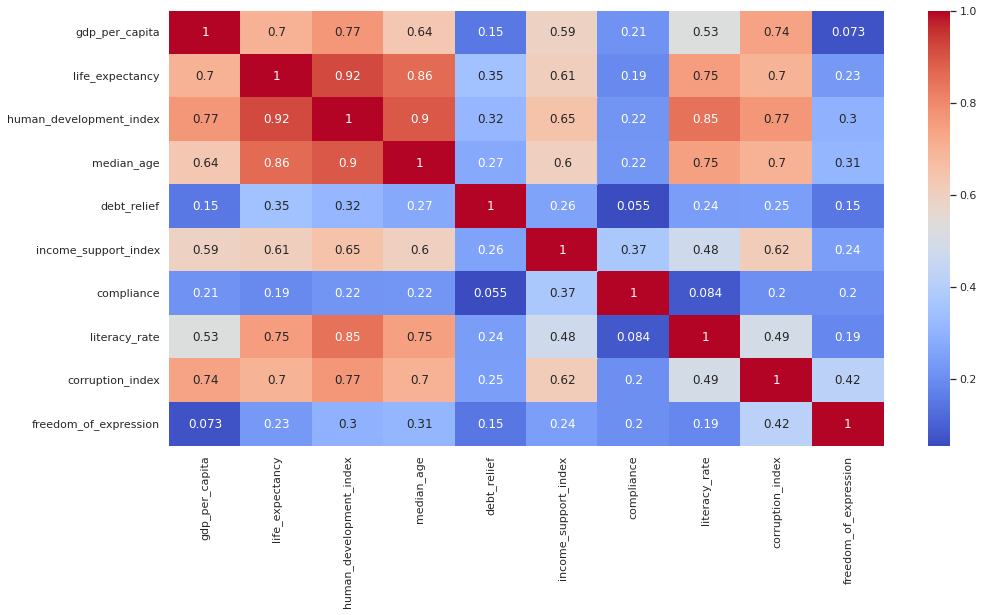

In [76]:
sns.heatmap(compliance_df.corr(), annot=True, cmap='coolwarm')

Identify outliers

In [77]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'debt_relief',
       'income_support_index', 'compliance', 'literacy_rate',
       'corruption_index', 'freedom_of_expression'],
      dtype='object')

In [78]:
# Calculate logs and squares and replot graph below
X, y = feature_engineering(compliance_df, 'compliance', keep_country=True)

In [79]:
# # Investigating empty graphs
# x = X["human_development_index_log"]
# plt.scatter(x, y)
# a, b = np.polyfit(x, y, 1)

# plt.plot(x, a*x+b, color='red')
# plt.title('Correlation between {} and Compliance'.format(feature))
# plt.xlabel(feature)
# plt.ylabel('Compliance')

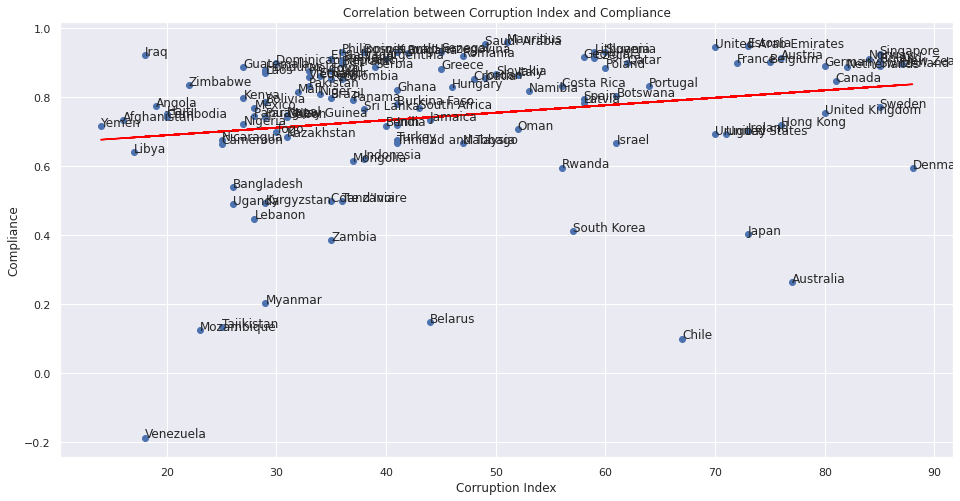

0.20372333229140596


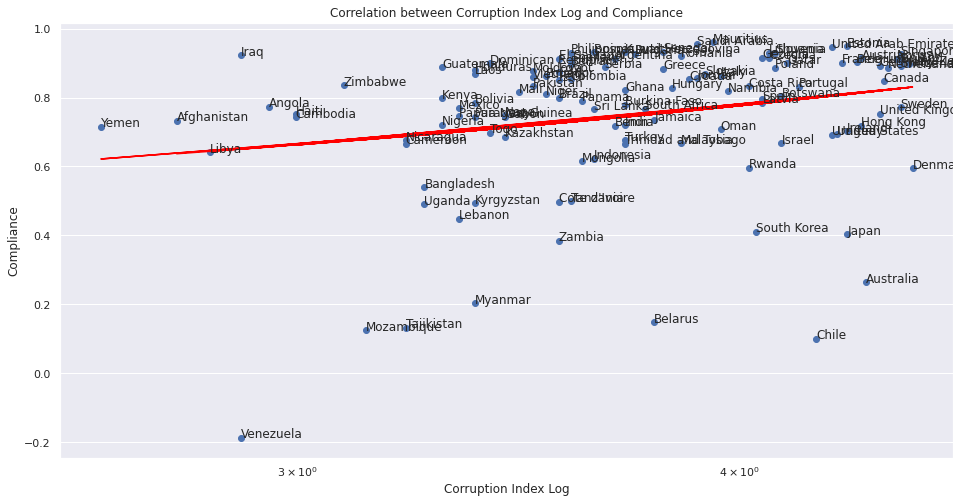

0.23728843094500987


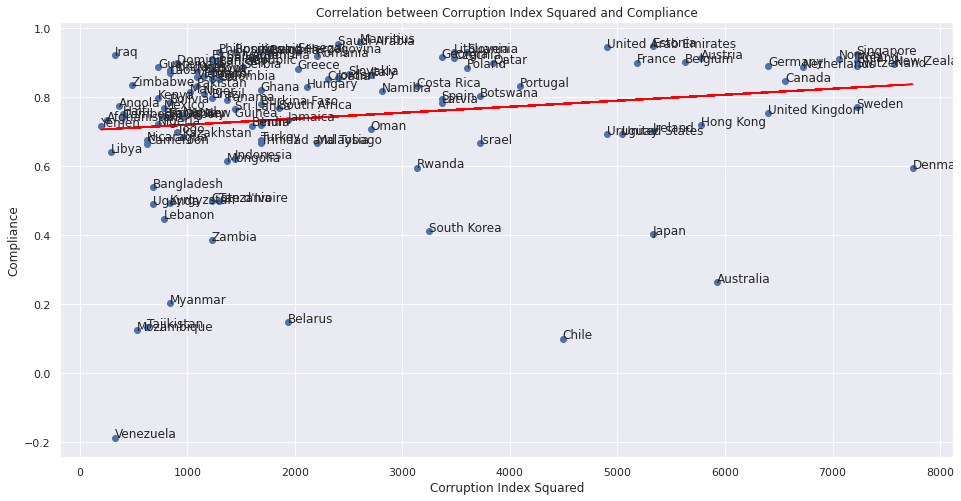

0.17156810936547262


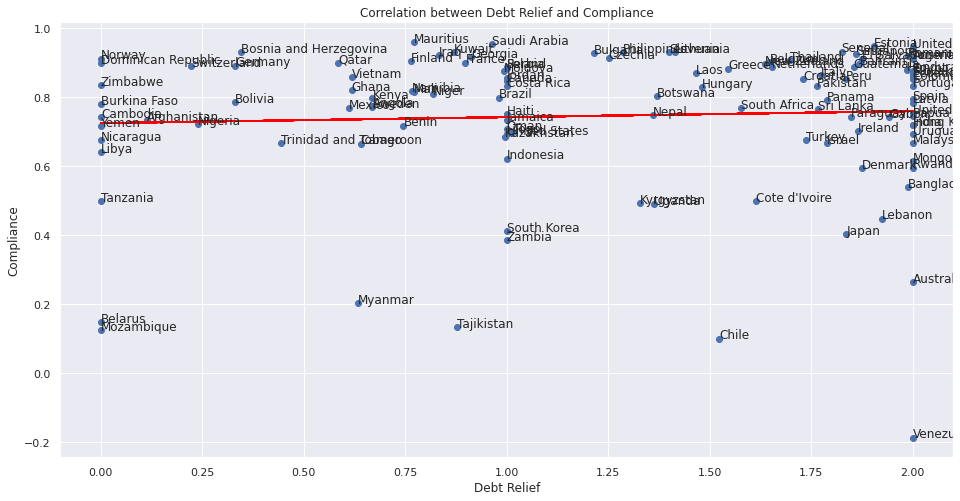

0.05519282700240693


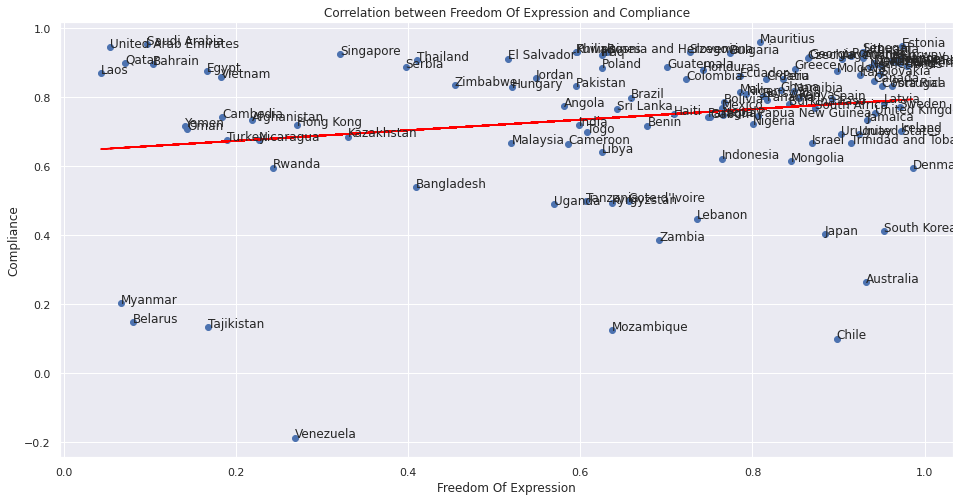

0.20373765302580077


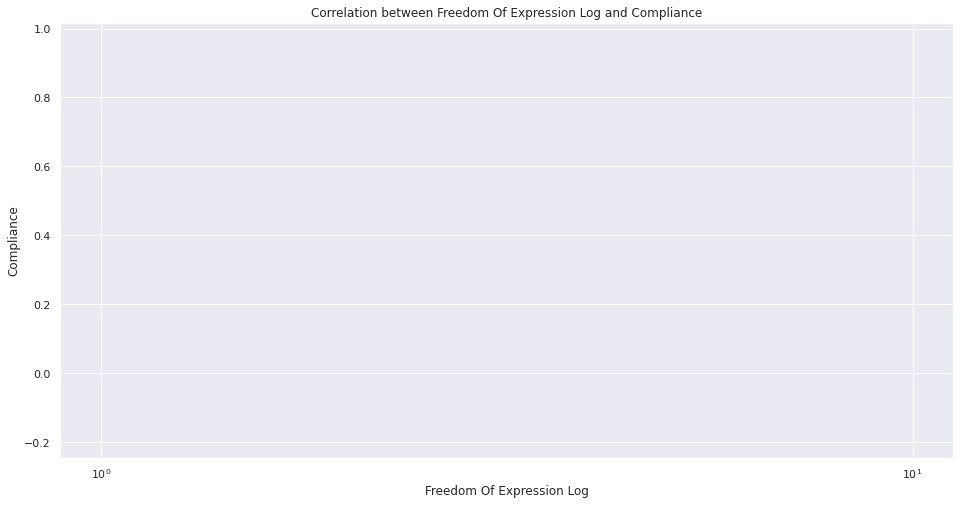

0.17333627830154646


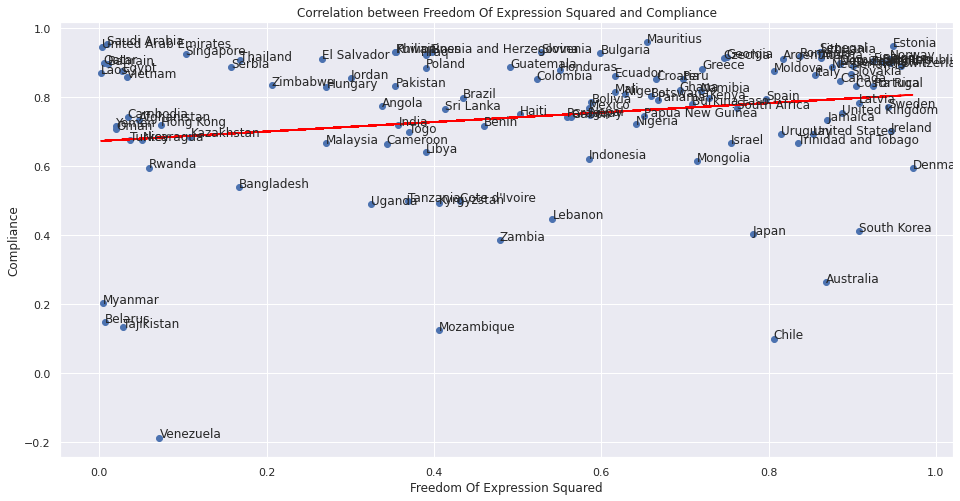

0.20612302297673132


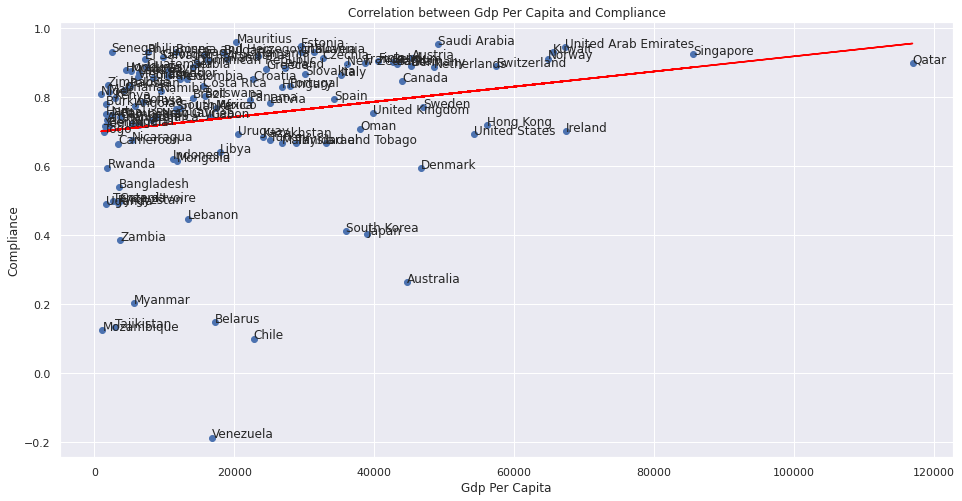

0.21442297160414403


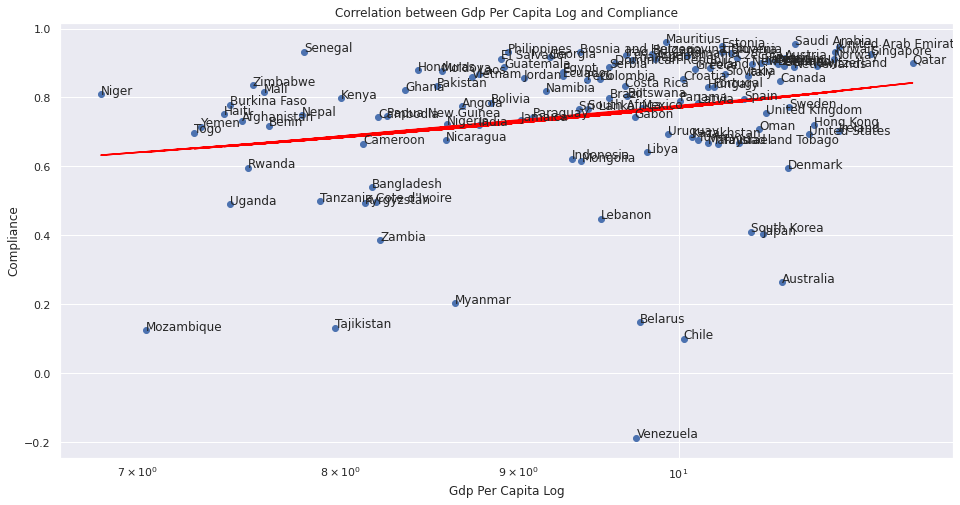

0.23633804627072807


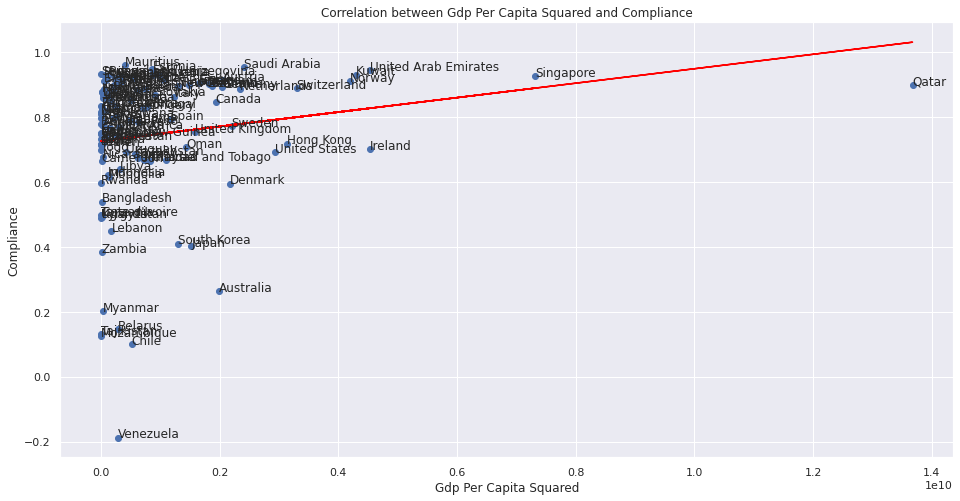

0.17992284520403776


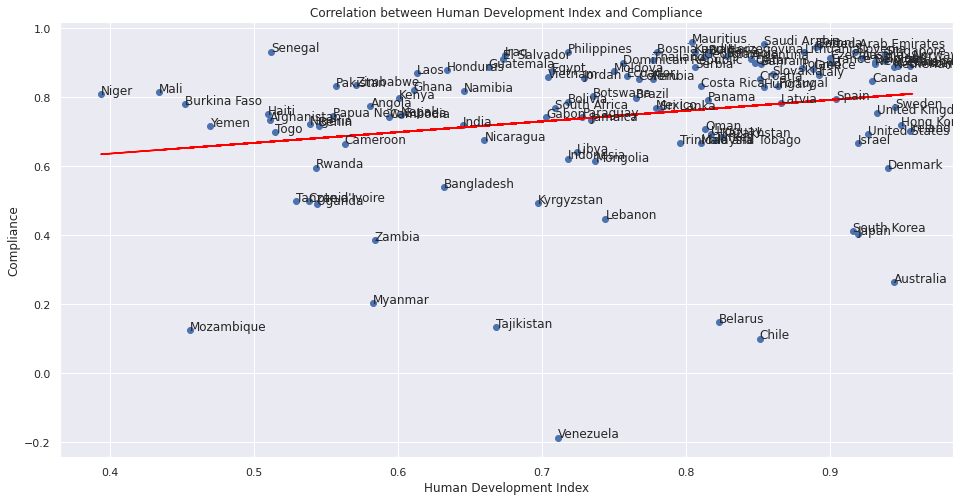

0.21857459289708916


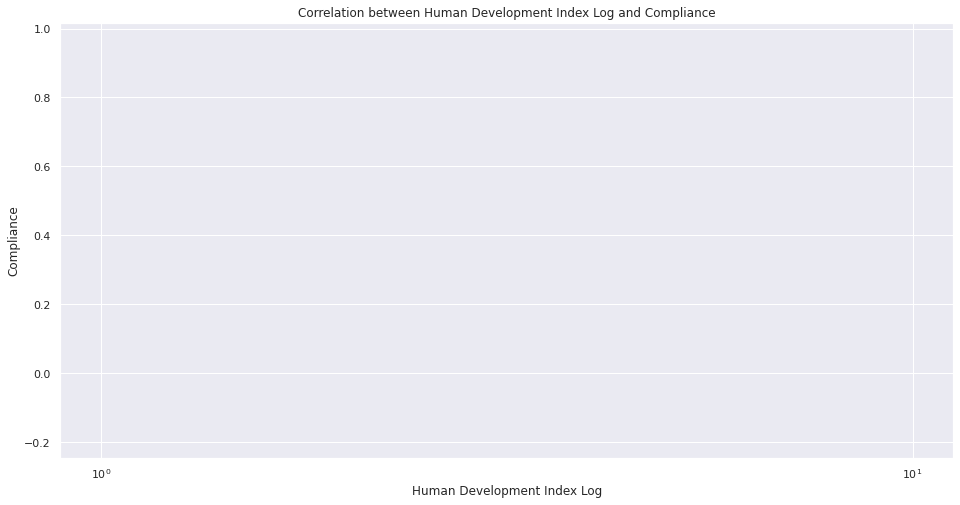

0.21593317273925555


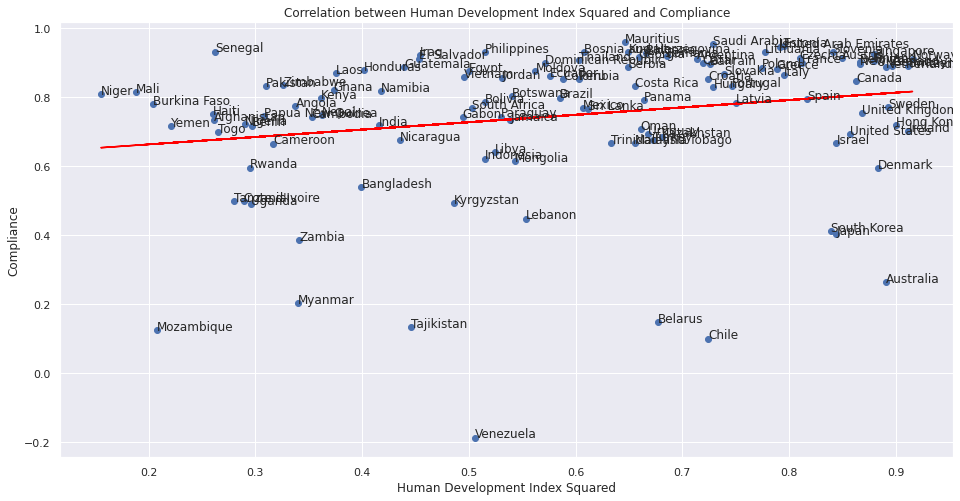

0.2170786808538608


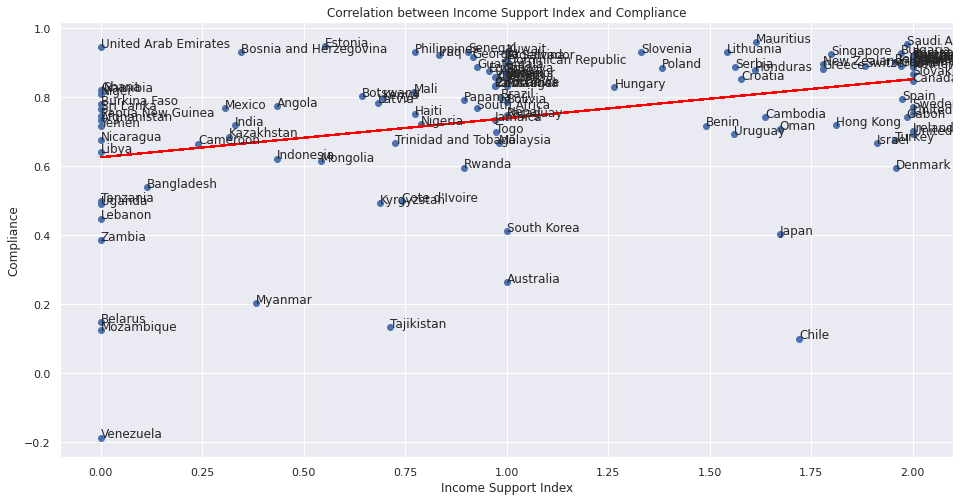

0.3729378499129005


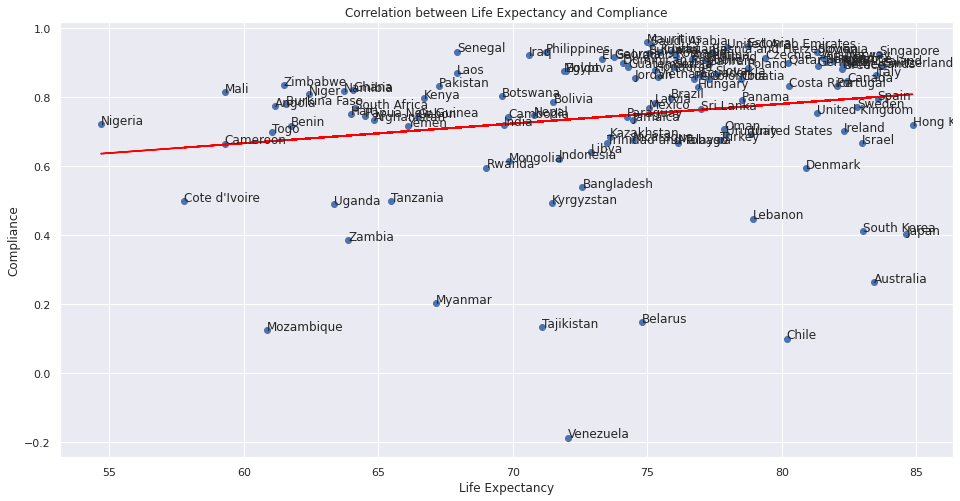

0.19419697066121483


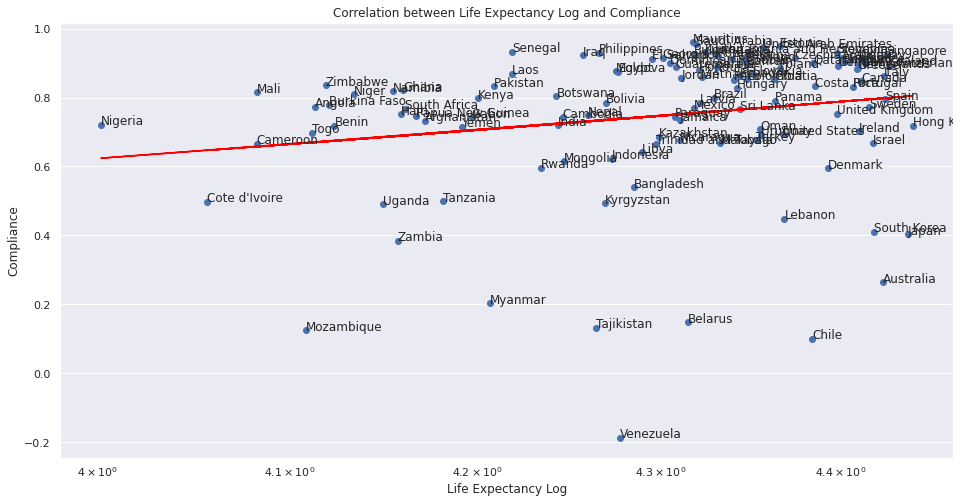

0.19655432280550714


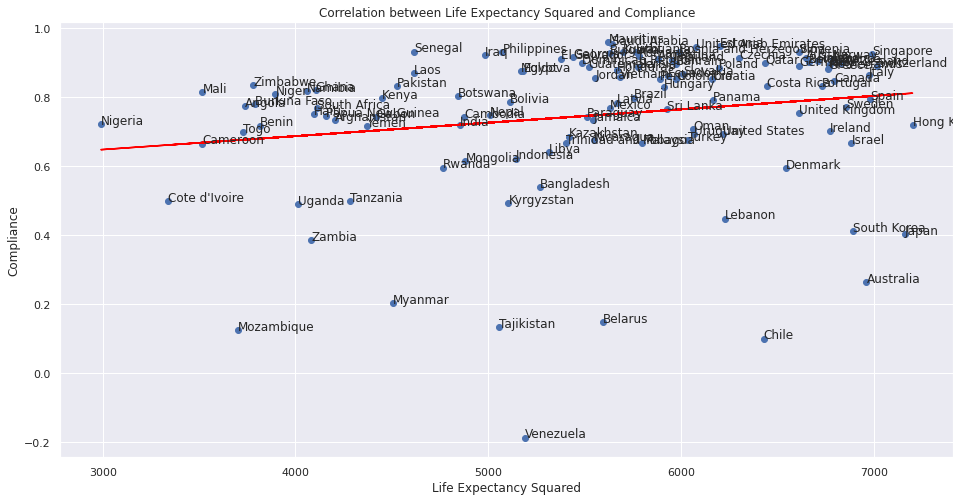

0.19080550233612031


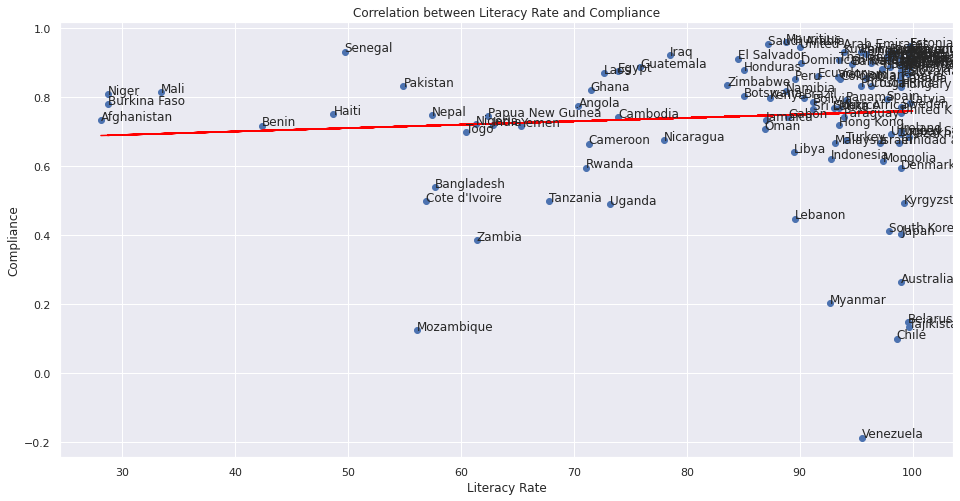

0.0836437293234651


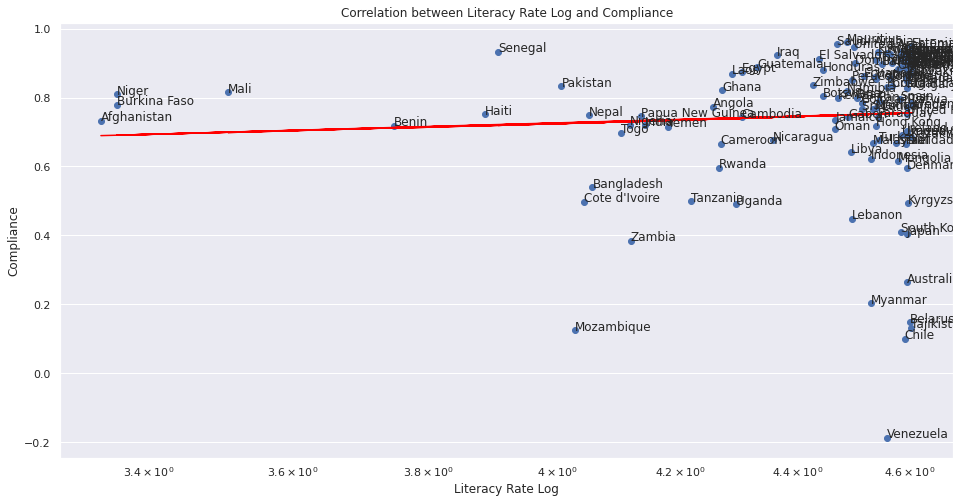

0.06750883999289926


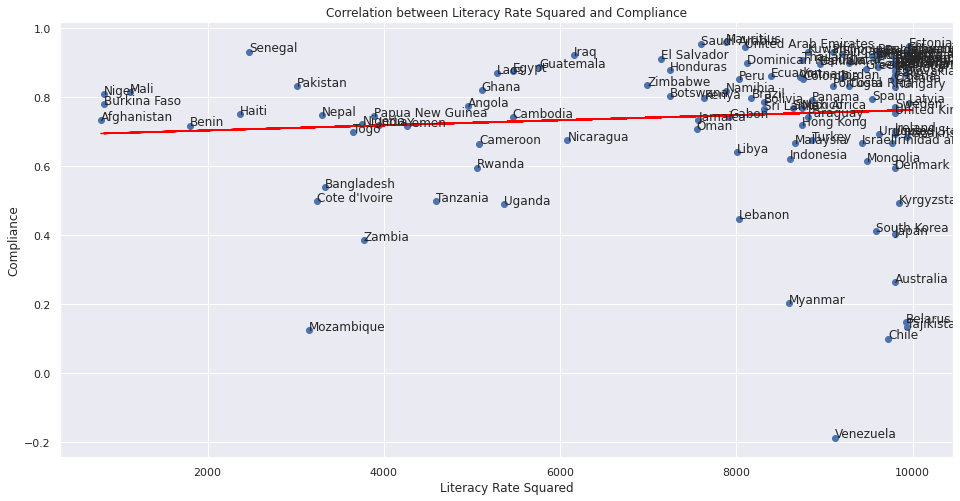

0.09091931448217623


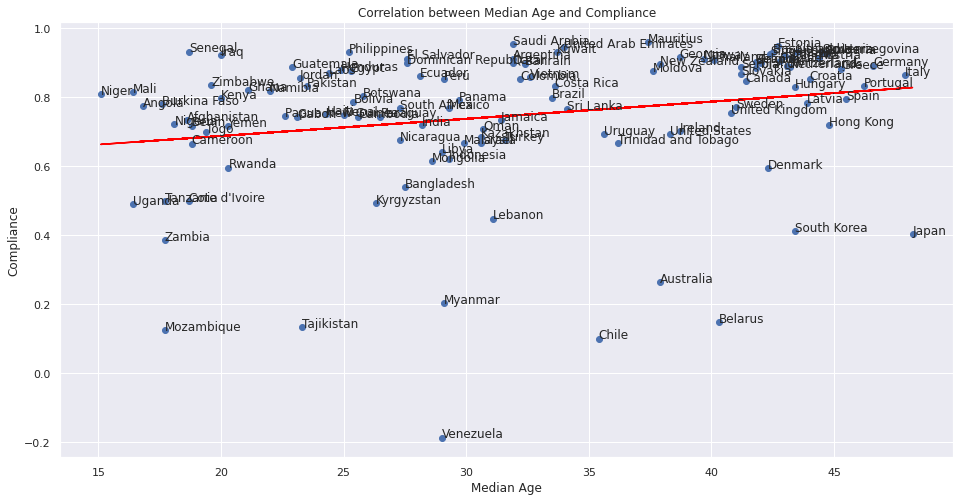

0.22147169862490762


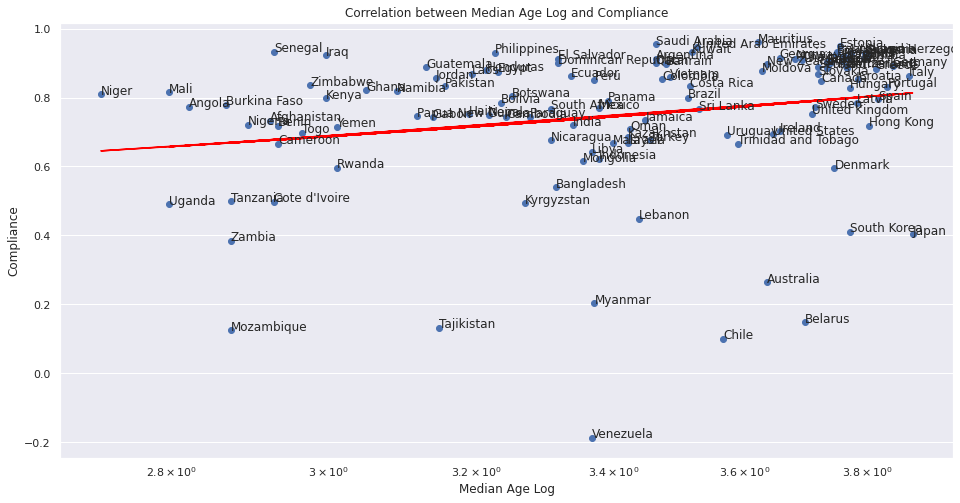

0.21627717600094246


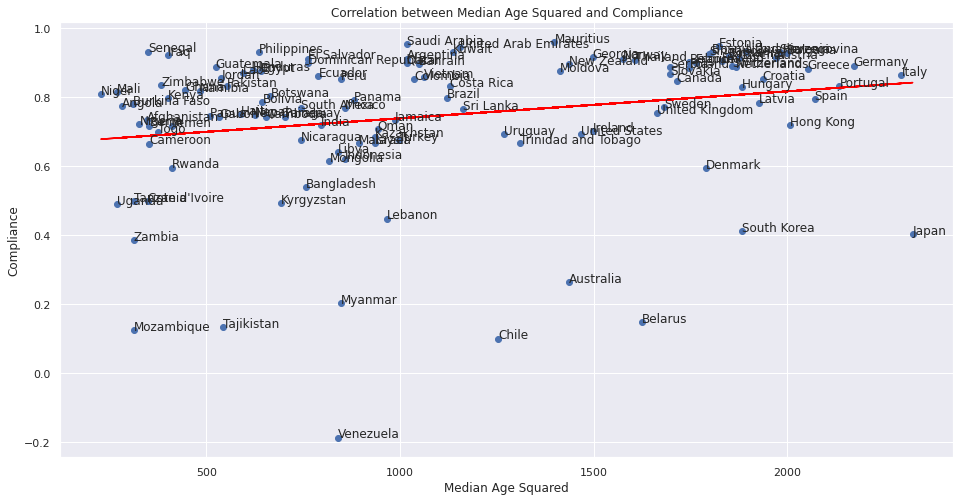

0.22297889402262525


In [80]:
for feature in sorted(X.columns):
    try:
        if feature == 'country': # Skip the country column
            continue
        x = X[feature]
        plt.scatter(x, y)
        a, b = np.polyfit(x, y, 1)
        
        plt.plot(x, a*x+b, color='red')
        plt.title('Correlation between {} and Compliance'.format(space_and_title_case(feature)))
        plt.xlabel(space_and_title_case(feature))
        plt.ylabel('Compliance')

        for i, txt in zip(X.index, X['country']):
            plt.annotate(txt, (x[i], y[i]), clip_on=True)

        if feature.endswith('log'):
            plt.xscale('log')
        else:
            plt.xscale('linear')
            
        plt.show()
        print(x.corr(y))
    except Exception as e:
        print(e)
        continue

##### Modelling:

In [81]:
X, y = feature_engineering(compliance_df, 'compliance', add_logs=False, add_squares=False)
X['gdp_per_capita_log'] = X['gdp_per_capita']
X.drop(columns=['gdp_per_capita', 'human_development_index'], inplace=True)

In [82]:
feature_importance_df = pd.DataFrame(columns=['feature', 'corr', 'corr_squared'])
for feature in X.columns[1:]:
    feature_importance_df = feature_importance_df.append(
        pd.Series((feature, X[feature].corr(y), X[feature].corr(y)**2), index = ['feature', 'corr', 'corr_squared']), 
           ignore_index=True)
feature_importance_df.sort_values(by='corr_squared', ascending=False, inplace=True)
feature_importance_df.head(15)

feature      corr  corr_squared
2   income_support_index  0.372938      0.139083
0             median_age  0.221472      0.049050
6     gdp_per_capita_log  0.214423      0.045977
5  freedom_of_expression  0.203738      0.041509
4       corruption_index  0.203723      0.041503
3          literacy_rate  0.083644      0.006996
1            debt_relief  0.055193      0.003046

In [83]:
feature_importance_df['features_cleaned_names'] = feature_importance_df['feature'].apply(lambda x: space_and_title_case(x))

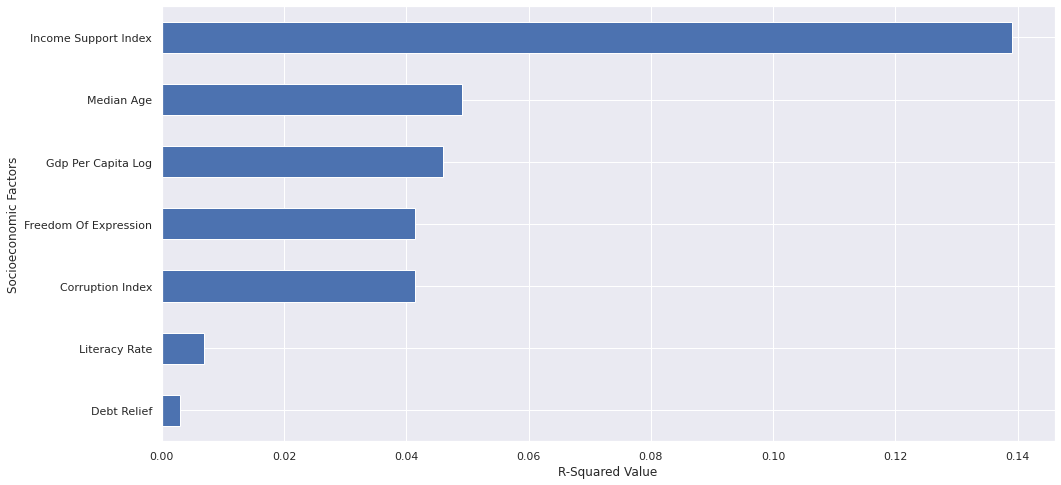

In [84]:
ax = feature_importance_df.plot('features_cleaned_names', 'corr_squared', kind='barh', legend=None)
ax.invert_yaxis()
plt.ylabel('Socioeconomic Factors')
plt.xlabel('R-Squared Value')
plt.tick_params(axis='x', labelrotation = 0)

In [85]:
insample_rsquared(X, y)

0.18730430203037474

In [86]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     3.111
Date:                Tue, 14 Jun 2022   Prob (F-statistic):            0.00336
Time:                        10:14:56   Log-Likelihood:                 29.591
No. Observations:                 117   AIC:                            -41.18
Df Residuals:                     108   BIC:                            -16.32
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.7065      0.320      2.211      0.029       0.073       1.340
life_expectancy           0.0003      0.006      0.055      0.956      -0.012       0.012
median_age                0.0036      0.004      0.832      0.407      -0.005       0.012
debt_relief              -0.0102      0.030     -0.343      0.732      -0.069       0.049
income_support_index      0.1192      0.036      3.288      0.001       0.047       0.191
literacy_rate            -0.0026      0.002     -1.592      0.114      -0.006       0.001
corruption_index         -0.0025      0.002     -1.398      0.165      -0.006       0.001
freedom_of_expression     0.1431      0.079      1.811      0.073      -0.014       0.300
gdp_per_capita_log     1.594e-06    1.6e-06      0.998      0.321   -1.57e-06    4.76e-06
==============================================================================
Omnibus:                       44.823   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.151
Skew:                          -1.540   Prob(JB):                     6.58e-23
Kurtosis:                       6.386   Cond. No.                     5.24e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

In [87]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [88]:
forward_included

['income_support_index']

In [89]:
insample_rsquared(X[forward_included], y)

0.13908263989765723

In [90]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     18.58
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           3.46e-05
Time:                        10:14:57   Log-Likelihood:                 26.219
No. Observations:                 117   AIC:                            -48.44
Df Residuals:                     115   BIC:                            -42.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6259      0.033     18.824      0.000       0.560       0.692
income_support_index     0.1132      0.026      4.310      0.000       0.061       0.165
==============================================================================
Omnibus:                       53.817   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.676
Skew:                          -1.817   Prob(JB):                     7.71e-31
Kurtosis:                       6.905   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [91]:
backward_included

['income_support_index']

In [92]:
insample_rsquared(X[backward_included], y)

0.13908263989765723

In [93]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     18.58
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           3.46e-05
Time:                        10:14:57   Log-Likelihood:                 26.219
No. Observations:                 117   AIC:                            -48.44
Df Residuals:                     115   BIC:                            -42.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6259      0.033     18.824      0.000       0.560       0.692
income_support_index     0.1132      0.026      4.310      0.000       0.061       0.165
==============================================================================
Omnibus:                       53.817   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.676
Skew:                          -1.817   Prob(JB):                     7.71e-31
Kurtosis:                       6.905   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

Text(0, 0.5, 'Mean compliance in pre-vaccination period (%)')

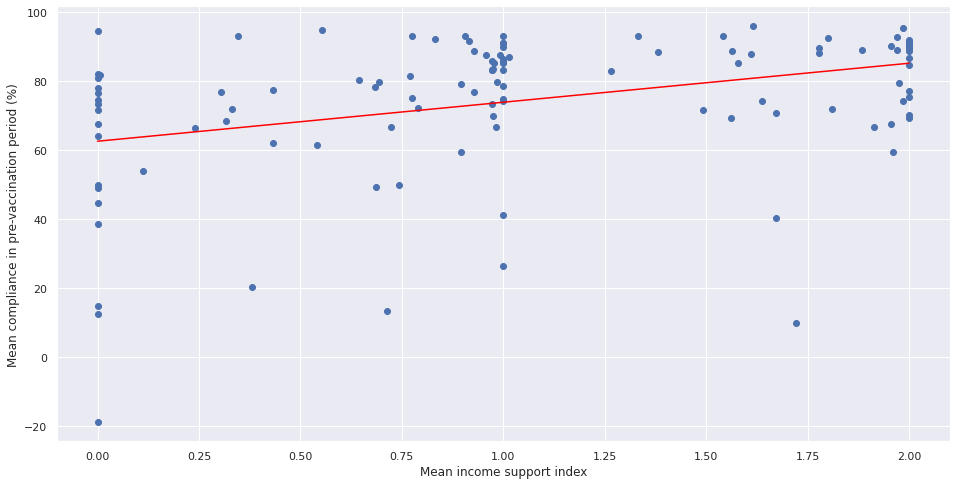

In [94]:
# Graphing income support index model
_ = []
for x in np.linspace(0, 2, 20):
    _.append(100 * (0.6259 + 0.1132*x))
plt.plot(np.linspace(0, 2, 20), _, color='red')
plt.scatter(X[backward_included], y*100)#Training data points
plt.xlabel("Mean income support index")
plt.ylabel("Mean compliance in pre-vaccination period (%)")

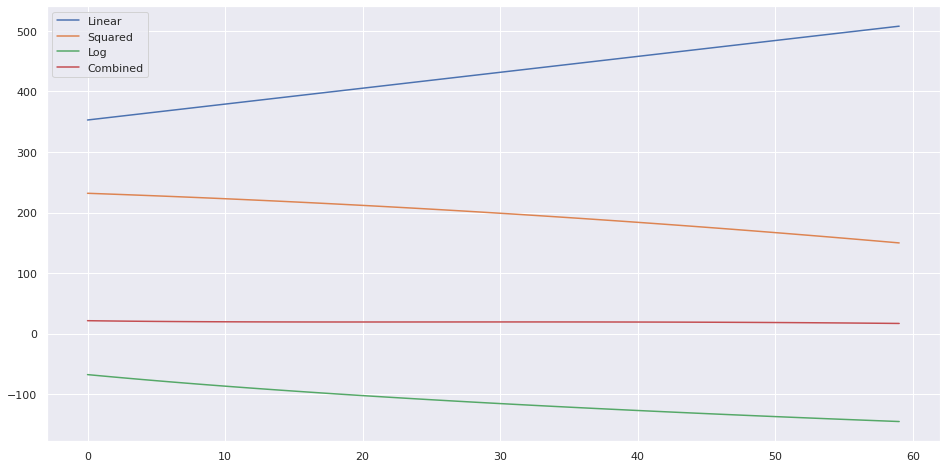

In [95]:
# Life expectancy investigation
_ = []
_sq = []
_log = []
_combined = []
for l_e in range(40,100):
    _.append(247.7772 + (2.6268)*l_e)
    _sq.append(247.7772 + (-0.0100)*(l_e**2))
    _log.append(247.7772 + np.log(l_e)*(-85.5451))
    _combined.append(247.7772 + np.log(l_e)*(-85.5451) + (-0.0100)*(l_e**2) + (2.6268)*l_e)
plt.plot(_, label='Linear')
plt.plot(_sq, label='Squared')
plt.plot(_log, label='Log')
plt.plot(_combined, label='Combined')
plt.legend()

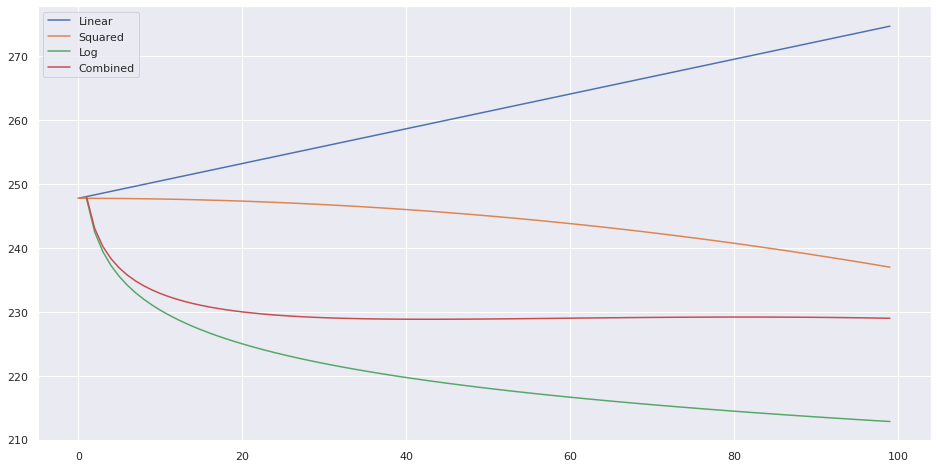

In [96]:
# Literacy rate investigation
_ = []
_sq = []
_log = []
_combined = []
for l_r in range(0,100):
    _.append(247.7772 + (0.2722)*l_r)
    _sq.append(247.7772 + (-0.0011)*(l_r**2))
    _log.append(247.7772 + np.log(l_r)*(-7.6050))
    _combined.append(247.7772 + np.log(l_r)*(-7.6050) + (-0.0011)*(l_r**2) + (0.2722)*l_r)
plt.plot(_, label='Linear')
plt.plot(_sq, label='Squared')
plt.plot(_log, label='Log')
plt.plot(_combined, label='Combined')
plt.legend()

In [97]:
np.min(compliance_df['literacy_rate'])

28.1

Top 10 compliant countries

In [98]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'debt_relief',
       'income_support_index', 'compliance', 'literacy_rate',
       'corruption_index', 'freedom_of_expression'],
      dtype='object')

---
**Note:**  
Taiwan has no GDP per capita  
Aruba, Belize and Fiji have no perceived corruption index

Europe

In [99]:
X, y = feature_engineering(compliance_df, 'compliance', add_logs=False, add_squares=False)
X['gdp_per_capita_log'] = X['gdp_per_capita']
X.drop(columns=['gdp_per_capita', 'human_development_index'], inplace=True)

In [100]:
continent_dict = {}
for continent, group in merged_df.groupby('continent'):
    continent_dict[continent] = set(group['country'])

X, y = feature_engineering(compliance_df[compliance_df['country'].isin(continent_dict['Europe'])], 'compliance', add_logs=False, add_squares=False)
X['gdp_per_capita_log'] = X['gdp_per_capita']
X.drop(columns=['gdp_per_capita', 'human_development_index'], inplace=True)
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     2.957
Date:                Tue, 14 Jun 2022   Prob (F-statistic):             0.0209
Time:                        10:14:59   Log-Likelihood:                 26.752
No. Observations:                  31   AIC:                            -35.50
Df Residuals:                      22   BIC:                            -22.60
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.5880      3.433     -0.754      0.459      -9.708       4.532
life_expectancy           0.0069      0.014      0.476      0.639      -0.023       0.037
median_age                0.0128      0.012      1.026      0.316      -0.013       0.039
debt_relief              -0.0536      0.041     -1.319      0.201      -0.138       0.031
income_support_index      0.0868      0.051      1.690      0.105      -0.020       0.193
literacy_rate             0.0217      0.029      0.740      0.467      -0.039       0.082
corruption_index         -0.0033      0.003     -1.152      0.262      -0.009       0.003
freedom_of_expression     0.5541      0.161      3.434      0.002       0.219       0.889
gdp_per_capita_log    -4.036e-06   3.81e-06     -1.060      0.301   -1.19e-05    3.86e-06
==============================================================================
Omnibus:                        1.810   Durbin-Watson:                   2.502
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                0.870
Skew:                          -0.374   Prob(JB):                        0.647
Kurtosis:                       3.339   Cond. No.                     5.81e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [102]:
forward_included

['freedom_of_expression', 'corruption_index']

In [103]:
backward_included

['corruption_index', 'freedom_of_expression']

In [104]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     8.585
Date:                Tue, 14 Jun 2022   Prob (F-statistic):            0.00124
Time:                        10:15:00   Log-Likelihood:                 22.848
No. Observations:                  31   AIC:                            -39.70
Df Residuals:                      28   BIC:                            -35.39
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5974      0.102      5.876      0.000       0.389       0.806
freedom_of_expression     0.5514      0.133      4.138      0.000       0.278       0.824
corruption_index         -0.0036      0.002     -2.208      0.036      -0.007      -0.000
==============================================================================
Omnibus:                        5.515   Durbin-Watson:                   2.480
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.880
Skew:                          -0.791   Prob(JB):                        0.144
Kurtosis:                       3.709   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     8.585
Date:                Tue, 14 Jun 2022   Prob (F-statistic):            0.00124
Time:                        10:15:00   Log-Likelihood:                 22.848
No. Observations:                  31   AIC:                            -39.70
Df Residuals:                      28   BIC:                            -35.39
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5974      0.102      5.876      0.000       0.389       0.806
corruption_index         -0.0036      0.002     -2.208      0.036      -0.007      -0.000
freedom_of_expression     0.5514      0.133      4.138      0.000       0.278       0.824
==============================================================================
Omnibus:                        5.515   Durbin-Watson:                   2.480
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.880
Skew:                          -0.791   Prob(JB):                        0.144
Kurtosis:                       3.709   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

Compliance regressions by continent

In [106]:
continent_dict = {}
for continent, group in merged_df.groupby('continent'):
    continent_dict[continent] = set(group['country'])
    # print(continent,":", compliance_df[compliance_df['country'].isin(continent_dict[continent])].shape)
    # print(continent, ":", np.mean(group['gdp_per_capita']))

    X, y = feature_engineering(compliance_df[compliance_df['country'].isin(continent_dict[continent])], 'compliance')
    print(f"{continent} ({len(continent_dict[continent])} countries)",":", "In-sample r-squared:", insample_rsquared(X, y))
    backward_included = backward_regression(X, y)
    print("OLS regression with backward selected features:")
    print(sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary())
    print(X[backward_included].std())
    print("-"*20, "\n")

Africa (55 countries) : In-sample r-squared: 0.9996393979524602
OLS regression with backward selected features:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     13.07
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           0.000493
Time:                        10:15:01   Log-Likelihood:                 48.294
No. Observations:                  25   AIC:                            -62.59
Df Residuals:                       8   BIC:                            -41.87
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975

---

Dummy vars for continent

In [107]:
X, y = feature_engineering(compliance_df, 'compliance', keep_country=True)
X['continent'] = X['country'].apply(lambda x: merged_df[merged_df['country'] == x]['continent'].values[0])
X = pd.get_dummies(X, columns=['continent'])
X.drop(columns=['country'], inplace=True)
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     2.983
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           5.30e-05
Time:                        10:15:03   Log-Likelihood:                 56.497
No. Observations:                 117   AIC:                            -54.99
Df Residuals:                      88   BIC:                             25.11
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             156.8949    131.887      1.190      0.237    -105.203     418.992
gdp_per_capita                  -7.769e-06   9.03e-06     -0.860      0.392   -2.57e-05    1.02e-05
life_expectancy                     2.1843      1.584      1.379      0.171      -0.963       5.332
human_development_index            31.0934     26.286      1.183      0.240     -21.145      83.332
median_age                         -0.2636      0.203     -1.300      0.197      -0.667       0.139
debt_relief                        -0.0229      0.031     -0.749      0.456      -0.084       0.038
income_support_index                0.1316      0.034      3.857      0.000       0.064       0.199
literacy_rate                       0.3075      0.079      3.872      0.000       0.150       0.465
corruption_index                   -0.0086      0.029     -0.297      0.767      -0.066       0.049
freedom_of_expression               1.4792      1.120      1.321      0.190      -0.746       3.705
gdp_per_capita_log                 -0.0072      0.099     -0.073      0.942      -0.203       0.189
gdp_per_capita_squared           8.455e-11   6.07e-11      1.394      0.167    -3.6e-11    2.05e-10
life_expectancy_log               -70.9233     54.386     -1.304      0.196    -179.004      37.157
life_expectancy_squared            -0.0084      0.006     -1.464      0.147      -0.020       0.003
human_development_index_log       -10.3519      8.215     -1.260      0.211     -26.678       5.975
human_development_index_squared   -10.2303     10.135     -1.009      0.316     -30.371       9.910
median_age_log                      3.6713      2.974      1.234      0.220      -2.240       9.582
median_age_squared                  0.0022      0.002      1.349      0.181      -0.001       0.006
literacy_rate_log                  -8.4671      2.250     -3.764      0.000     -12.938      -3.997
literacy_rate_squared              -0.0013      0.000     -4.079      0.000      -0.002      -0.001
corruption_index_log                0.2410      0.598      0.403      0.688      -0.948       1.430
corruption_index_squared           4.5e-05      0.000      0.282      0.778      -0.000       0.000
freedom_of_expression_log          -0.1385      0.182     -0.761      0.448      -0.500       0.223
freedom_of_expression_squared      -0.8447      0.661     -1.278      0.205      -2.158       0.469
continent_Africa                   26.0887     22.003      1.186      0.239     -17.637      69.814
continent_Asia                     26.1689     21.985      1.190      0.237     -17.522      69.860
continent_Europe                   26.2692     21.965      1.196      0.235     -17.381      69.919
continent_North America            26.1602     21.973      1.191      0.237     -17

In [108]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [109]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     18.58
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           3.46e-05
Time:                        10:15:04   Log-Likelihood:                 26.219
No. Observations:                 117   AIC:                            -48.44
Df Residuals:                     115   BIC:                            -42.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6259      0.033     18.824      0.000       0.560       0.692
income_support_index     0.1132      0.026      4.310      0.000       0.061       0.165
==============================================================================
Omnibus:                       53.817   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.676
Skew:                          -1.817   Prob(JB):                     7.71e-31
Kurtosis:                       6.905   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     6.960
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           2.28e-07
Time:                        10:15:04   Log-Likelihood:                 41.782
No. Observations:                 117   AIC:                            -65.56
Df Residuals:                     108   BIC:                            -40.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              16.9766      4.910      3.458      0.001       7.244      26.709
human_development_index             4.7771      1.731      2.760      0.007       1.347       8.207
income_support_index                0.1265      0.033      3.874      0.000       0.062       0.191
literacy_rate                       0.2490      0.069      3.627      0.000       0.113       0.385
freedom_of_expression               0.1418      0.066      2.144      0.034       0.011       0.273
human_development_index_squared    -2.9626      1.132     -2.617      0.010      -5.207      -0.719
literacy_rate_log                  -7.1805      1.940     -3.701      0.000     -11.027      -3.335
literacy_rate_squared              -0.0010      0.000     -3.733      0.000      -0.002      -0.000
continent_Europe                    0.1578      0.050      3.136      0.002       0.058       0.257
==============================================================================
Omnibus:                       28.594   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.433
Skew:                          -1.029   Prob(JB):                     1.51e-12
Kurtosis:                       5.632   Cond. No.                     2.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""